# **SENTIMENT ANALYSIS ON SKINCARE PRODUCT REVIEWS IN AMAZON PLAFORM**

## 1.0 Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
sns.set_style("whitegrid")

#set warning
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

## 2.0 Load Data

In [2]:
# Specify the path to the concatenated file
cleaned_file_path = 'concatenated_data_new.csv'

# Load the concatenated file into a DataFrame
cleaned_amazon_reviews = pd.read_csv(cleaned_file_path)

# Make a copy of raw data into a df DataFrame
df = cleaned_amazon_reviews.copy()

In [3]:
# Output data
df.head(5)

,product,date,title,rating,body,helpful_count
0,Amazon.com: Customer reviews: CeraVe Foaming F...,28/07/2021,1.0 out of 5 stars\nthere’s no way these revie...,1.0,I bought this because I’ve had really oily ski...,2
1,Amazon.com: Customer reviews: CeraVe Foaming F...,23/07/2023,1.0 out of 5 stars\nNot paraben free,1.0,I don’t understand how these brand name compan...,3
2,Amazon.com: Customer reviews: CeraVe Foaming F...,03/03/2022,1.0 out of 5 stars\nCaused reaction- proceed w...,1.0,Bought this for my child to use as a face wash...,10
3,Amazon.com: Customer reviews: CeraVe Foaming F...,28/06/2020,1.0 out of 5 stars\nSlimey,1.0,"So, you know that slime you make when you mix ...",6
4,Amazon.com: Customer reviews: CeraVe Foaming F...,10/12/2023,1.0 out of 5 stars\nProducto abierto,1.0,El producto venía abierto y quedó todo el líqu...,0


## 3.0 Data Exploration

### 3.1 Dataset Shape

In [4]:
# Dataset shape (row, column)
df.shape

(15641, 6)

### 3.2 Missing Values

In [5]:
# Check for missing values
df.isna().sum()

product           0
date              0
title             0
rating            0
body             60
helpful_count     0
dtype: int64

### 3.3 Duplicated Rows

In [6]:
# Check for duplicate rows
num_duplicate_rows = df.duplicated().sum()
num_duplicate_rows

3663

## 4.0 Data Preparation

### 4.1 Rename Columns

In [7]:
# Rename columns to make the dataset easier to understand
df.rename(columns={'title': 'Title'}, inplace=True)
df.rename(columns={'rating': 'Rating'}, inplace=True)
df.rename(columns={'body': 'Review'}, inplace=True)
df.rename(columns={'product': 'Product'}, inplace=True)
df.rename(columns={'date': 'Date'}, inplace=True)
df.rename(columns={'helpful_count': 'Helpful Count'}, inplace=True)

### 4.2 Add New Columns - Skin Concern, Brand, Product Type

In [8]:
# Mapping dictionary (replace these values with your actual mapping)
product_to_skin_concern = {
    # acne-oily-skin
    'Amazon.com: Customer reviews: CeraVe Foaming Facial Cleanser | Daily Face Wash for Oily Skin with Hyaluronic Acid, Ceramides, and Niacinamide| Fragrance Free Paraben Free | 19 Fluid Ounce': 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Purifying Foaming Gel Cleanser for Oily Skin, pH Balancing Daily Face Wash, Oil Free and Soap Free, 13.52 Fl Oz (Pack of 1)': 'acne and oily',
    'Amazon.com: Customer reviews: CeraVe Salicylic Acid Acne Treatment with Glycolic Acid and Lactic Acid | AHA/BHA Acne Gel for Face to Control and Clear Breakouts |1.35 Ounce': 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Duo Dual Action Acne Spot Treatment Cream with Benzoyl Peroxide Acne Treatment for Acne and Blackheads, Lightweight Sheerness, Safe For Sensitive Skin ,0.7 Fl Oz' : 'acne and oily',
    'Amazon.com: Customer reviews: CeraVe AM Facial Moisturizing Lotion SPF 30 | Oil-Free Face Moisturizer with Sunscreen | Non-Comedogenic | 3 Ounce' : 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Mat Oil-Free Mattifying Moisturizer' : 'acne and oily',
    'Amazon.com: Customer reviews: CeraVe Retinol Serum for Post-Acne Marks and Skin Texture | Pore Refining, Resurfacing, Brightening Facial Serum with Retinol and Niacinamide | Fragrance Free, Paraben Free &amp; Non-Comedogenic| 1 Oz' : 'acne and oily',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Salicylic Acid Acne Treatment to Minimize Pores, Clear Acne Blemishes and Post Acne Marks' : 'acne and oily',

    # anti-aging skin
    'Amazon.com: Customer reviews: CeraVe Anti Aging Face Cream with SPF 30 Sunscreen | Anti Wrinkle Cream for Face with Retinol, SPF 30 Sunscreen, Hyaluronic Acid, and Ceramides | White,1.76 Ounce (Pack of 1)' : 'anti-aging',
    'Amazon.com: Customer reviews: La Roche-Posay Redermic R Anti Aging Retinol Cream, Reduces Wrinkles, Fine Lines, and Age Spots with Pure Retinol Face Cream, 1 Fl Oz' : 'anti-aging',
    'Amazon.com: Customer reviews: CeraVe Eye Cream for Wrinkles | Under Eye Cream with Caffeine, Peptides, Hyaluronic Acid, Niacinamide, and Ceramides for Fine Lines | Fragrance Free &amp; Ophthalmologist Tested |0.5 Ounces' : 'anti-aging',
    'Amazon.com: Customer reviews: La Roche-Posay Pigmentclar Dark Circles Eye Cream with Caffeine, Brightens Under Eye Area and Targets Dark Circles' : 'anti-aging',
    'Amazon.com: Customer reviews: CeraVe Anti Aging Retinol Serum | Cream Serum for Smoothing Fine Lines and Skin Brightening | With Retinol, Hyaluronic Acid, Niacinamide, and Ceramides | 1 Ounce' : 'anti-aging',
    'Amazon.com: Customer reviews: La Roche-Posay Pure Retinol Face Serum with Vitamin B3. Anti Aging Face Serum for Lines, Wrinkles &amp; Premature Sun Damage to Resurface &amp; Hydrate. Suitable for Sensitive Skin, 1.0 Fl. Oz' : 'anti-aging',

    # dry skin
    'Amazon.com: Customer reviews: CeraVe Hydrating Facial Cleanser | Moisturizing Non-Foaming Face Wash with Hyaluronic Acid, Ceramides and Glycerin | Fragrance Free Paraben Free | 16 Fluid Ounce' : 'dry',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Hydrating Gentle Face Cleanser, Daily Facial Cleanser with Niacinamide and Ceramides for Sensitive Skin, Moisturizing Face Wash for Normal to Dry Skin, Fragrance Free' : 'dry',
    'Amazon.com: Customer reviews: CeraVe Daily Moisturizing Lotion for Dry Skin | Body Lotion &amp; Facial Moisturizer with Hyaluronic Acid and Ceramides | Fragrance Free | 19 Ounce' : 'dry',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Double Repair Face Moisturizer, Daily Moisturizer Face Cream with Ceramide and Niacinamide for All Skin Types, Oil Free, Fragrance Free' : 'dry',
    'Amazon.com: Customer reviews: Cerave Hyaluronic Acid Serum for Face with Vitamin B5 and Ceramides | Hydrating Face Serum for Dry Skin | Fragrance Free | 1 Ounce' : 'dry',
    'Amazon.com: Customer reviews: La Roche-Posay Hyalu B5 Pure Hyaluronic Acid Serum for Face, with Vitamin B5, Anti-Aging Serum for Fine Lines and Wrinkles, Hydrating Serum to Plump and Repair Dry Skin, Safe on Sensitive Skin' : 'dry',
}

product_to_brand = {
    # acne-oily-skin
    'Amazon.com: Customer reviews: CeraVe Foaming Facial Cleanser | Daily Face Wash for Oily Skin with Hyaluronic Acid, Ceramides, and Niacinamide| Fragrance Free Paraben Free | 19 Fluid Ounce': 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Purifying Foaming Gel Cleanser for Oily Skin, pH Balancing Daily Face Wash, Oil Free and Soap Free, 13.52 Fl Oz (Pack of 1)': 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Salicylic Acid Acne Treatment with Glycolic Acid and Lactic Acid | AHA/BHA Acne Gel for Face to Control and Clear Breakouts |1.35 Ounce': 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Duo Dual Action Acne Spot Treatment Cream with Benzoyl Peroxide Acne Treatment for Acne and Blackheads, Lightweight Sheerness, Safe For Sensitive Skin ,0.7 Fl Oz' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe AM Facial Moisturizing Lotion SPF 30 | Oil-Free Face Moisturizer with Sunscreen | Non-Comedogenic | 3 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Mat Oil-Free Mattifying Moisturizer' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Retinol Serum for Post-Acne Marks and Skin Texture | Pore Refining, Resurfacing, Brightening Facial Serum with Retinol and Niacinamide | Fragrance Free, Paraben Free &amp; Non-Comedogenic| 1 Oz' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Salicylic Acid Acne Treatment to Minimize Pores, Clear Acne Blemishes and Post Acne Marks' : 'La Roche-Posay',

    # anti-aging skin
    'Amazon.com: Customer reviews: CeraVe Anti Aging Face Cream with SPF 30 Sunscreen | Anti Wrinkle Cream for Face with Retinol, SPF 30 Sunscreen, Hyaluronic Acid, and Ceramides | White,1.76 Ounce (Pack of 1)' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Redermic R Anti Aging Retinol Cream, Reduces Wrinkles, Fine Lines, and Age Spots with Pure Retinol Face Cream, 1 Fl Oz' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Eye Cream for Wrinkles | Under Eye Cream with Caffeine, Peptides, Hyaluronic Acid, Niacinamide, and Ceramides for Fine Lines | Fragrance Free &amp; Ophthalmologist Tested |0.5 Ounces' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Pigmentclar Dark Circles Eye Cream with Caffeine, Brightens Under Eye Area and Targets Dark Circles' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Anti Aging Retinol Serum | Cream Serum for Smoothing Fine Lines and Skin Brightening | With Retinol, Hyaluronic Acid, Niacinamide, and Ceramides | 1 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Pure Retinol Face Serum with Vitamin B3. Anti Aging Face Serum for Lines, Wrinkles &amp; Premature Sun Damage to Resurface &amp; Hydrate. Suitable for Sensitive Skin, 1.0 Fl. Oz' : 'La Roche-Posay',

    # dry skin
    'Amazon.com: Customer reviews: CeraVe Hydrating Facial Cleanser | Moisturizing Non-Foaming Face Wash with Hyaluronic Acid, Ceramides and Glycerin | Fragrance Free Paraben Free | 16 Fluid Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Hydrating Gentle Face Cleanser, Daily Facial Cleanser with Niacinamide and Ceramides for Sensitive Skin, Moisturizing Face Wash for Normal to Dry Skin, Fragrance Free' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: CeraVe Daily Moisturizing Lotion for Dry Skin | Body Lotion &amp; Facial Moisturizer with Hyaluronic Acid and Ceramides | Fragrance Free | 19 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Double Repair Face Moisturizer, Daily Moisturizer Face Cream with Ceramide and Niacinamide for All Skin Types, Oil Free, Fragrance Free' : 'La Roche-Posay',
    'Amazon.com: Customer reviews: Cerave Hyaluronic Acid Serum for Face with Vitamin B5 and Ceramides | Hydrating Face Serum for Dry Skin | Fragrance Free | 1 Ounce' : 'CeraVe',
    'Amazon.com: Customer reviews: La Roche-Posay Hyalu B5 Pure Hyaluronic Acid Serum for Face, with Vitamin B5, Anti-Aging Serum for Fine Lines and Wrinkles, Hydrating Serum to Plump and Repair Dry Skin, Safe on Sensitive Skin' : 'La Roche-Posay',
}

product_to_product_type = {
    # acne-oily-skin
    'Amazon.com: Customer reviews: CeraVe Foaming Facial Cleanser | Daily Face Wash for Oily Skin with Hyaluronic Acid, Ceramides, and Niacinamide| Fragrance Free Paraben Free | 19 Fluid Ounce': 'Cleanser',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Purifying Foaming Gel Cleanser for Oily Skin, pH Balancing Daily Face Wash, Oil Free and Soap Free, 13.52 Fl Oz (Pack of 1)': 'Cleanser',
    'Amazon.com: Customer reviews: CeraVe Salicylic Acid Acne Treatment with Glycolic Acid and Lactic Acid | AHA/BHA Acne Gel for Face to Control and Clear Breakouts |1.35 Ounce': 'Cream',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Duo Dual Action Acne Spot Treatment Cream with Benzoyl Peroxide Acne Treatment for Acne and Blackheads, Lightweight Sheerness, Safe For Sensitive Skin ,0.7 Fl Oz' : 'Cream',
    'Amazon.com: Customer reviews: CeraVe AM Facial Moisturizing Lotion SPF 30 | Oil-Free Face Moisturizer with Sunscreen | Non-Comedogenic | 3 Ounce' : 'Moisturizer',
    'Amazon.com: Customer reviews: La Roche-Posay Mat Oil-Free Mattifying Moisturizer' : 'Moisturizer',
    'Amazon.com: Customer reviews: CeraVe Retinol Serum for Post-Acne Marks and Skin Texture | Pore Refining, Resurfacing, Brightening Facial Serum with Retinol and Niacinamide | Fragrance Free, Paraben Free &amp; Non-Comedogenic| 1 Oz' : 'Serum',
    'Amazon.com: Customer reviews: La Roche-Posay Effaclar Salicylic Acid Acne Treatment to Minimize Pores, Clear Acne Blemishes and Post Acne Marks' : 'Serum',

    # anti-aging skin
    'Amazon.com: Customer reviews: CeraVe Anti Aging Face Cream with SPF 30 Sunscreen | Anti Wrinkle Cream for Face with Retinol, SPF 30 Sunscreen, Hyaluronic Acid, and Ceramides | White,1.76 Ounce (Pack of 1)' : 'Cream',
    'Amazon.com: Customer reviews: La Roche-Posay Redermic R Anti Aging Retinol Cream, Reduces Wrinkles, Fine Lines, and Age Spots with Pure Retinol Face Cream, 1 Fl Oz' : 'Cream',
    'Amazon.com: Customer reviews: CeraVe Eye Cream for Wrinkles | Under Eye Cream with Caffeine, Peptides, Hyaluronic Acid, Niacinamide, and Ceramides for Fine Lines | Fragrance Free &amp; Ophthalmologist Tested |0.5 Ounces' : 'Eye Cream',
    'Amazon.com: Customer reviews: La Roche-Posay Pigmentclar Dark Circles Eye Cream with Caffeine, Brightens Under Eye Area and Targets Dark Circles' : 'Eye Cream',
    'Amazon.com: Customer reviews: CeraVe Anti Aging Retinol Serum | Cream Serum for Smoothing Fine Lines and Skin Brightening | With Retinol, Hyaluronic Acid, Niacinamide, and Ceramides | 1 Ounce' : 'Serum',
    'Amazon.com: Customer reviews: La Roche-Posay Pure Retinol Face Serum with Vitamin B3. Anti Aging Face Serum for Lines, Wrinkles &amp; Premature Sun Damage to Resurface &amp; Hydrate. Suitable for Sensitive Skin, 1.0 Fl. Oz' : 'Serum',

    # dry skin
    'Amazon.com: Customer reviews: CeraVe Hydrating Facial Cleanser | Moisturizing Non-Foaming Face Wash with Hyaluronic Acid, Ceramides and Glycerin | Fragrance Free Paraben Free | 16 Fluid Ounce' : 'Cleanser',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Hydrating Gentle Face Cleanser, Daily Facial Cleanser with Niacinamide and Ceramides for Sensitive Skin, Moisturizing Face Wash for Normal to Dry Skin, Fragrance Free' : 'Cleanser',
    'Amazon.com: Customer reviews: CeraVe Daily Moisturizing Lotion for Dry Skin | Body Lotion &amp; Facial Moisturizer with Hyaluronic Acid and Ceramides | Fragrance Free | 19 Ounce' : 'Moisturizer',
    'Amazon.com: Customer reviews: La Roche-Posay Toleriane Double Repair Face Moisturizer, Daily Moisturizer Face Cream with Ceramide and Niacinamide for All Skin Types, Oil Free, Fragrance Free' : 'Moisturizer',
    'Amazon.com: Customer reviews: Cerave Hyaluronic Acid Serum for Face with Vitamin B5 and Ceramides | Hydrating Face Serum for Dry Skin | Fragrance Free | 1 Ounce' : 'Serum',
    'Amazon.com: Customer reviews: La Roche-Posay Hyalu B5 Pure Hyaluronic Acid Serum for Face, with Vitamin B5, Anti-Aging Serum for Fine Lines and Wrinkles, Hydrating Serum to Plump and Repair Dry Skin, Safe on Sensitive Skin' : 'Serum',
}

# Map 'Product' column values to 'Skin Concerns' based on the dictionary
df['Skin Concern'] = df['Product'].map(product_to_skin_concern)
df['Brand'] = df['Product'].map(product_to_brand)
df['Product Type'] = df['Product'].map(product_to_product_type)


### 4.3 Concatenate Title with Review Columns

In [9]:
# Extract subtitle from 'Title' column and concatenate with main review text
df['Title'] = df['Title'].apply(lambda x: x.split('\n')[1] if '\n' in x else '')
df['Review'] = df['Review']+df['Title']
df = df.drop(['Title'], axis=1)

### 4.4 Drop Non-English Reviews

In [10]:
!pip install langdetect

In [11]:
from langdetect import detect

# Define a function to detect the language of a text
def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return None

# Apply language detection to the 'Review' column and create a new column 'Language'
df['Language'] = df['Review'].apply(detect_language)

# Count the number of non-English reviews
non_english_count = df[df['Language'] != 'en'].shape[0]
print("Number of non-English reviews:", non_english_count)

# Drop rows where the detected language is not English
df = df[df['Language'] == 'en']

# Optionally, you can drop the 'Language' column if you don't need it anymore
df.drop(columns=['Language'], inplace=True)

Number of non-English reviews: 1453


### Drop Unnecessary Columns

In [12]:
# Drop the not needed columns for analysis
df.drop(columns = ['Product'], inplace = True)
df.drop(columns = ['Helpful Count'], inplace = True)
df.drop(columns = ['Date'], inplace = True)

In [13]:
df.shape

(14188, 5)

## 5.0 Data Pre-Processing

### 5.1 Data Cleaning

In [14]:
# Remove rows that contain empty cells
df.dropna(inplace = True)

# Remove duplicates
df.drop_duplicates(inplace = True)

In [15]:
df.shape

(8591, 5)

### 5.2 Case Folding

In [16]:
# Convert the 'review' column to lowercase
df['Review'] = df['Review'].str.lower()

In [17]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['Review Len'] = df['Review'].apply(lambda x: len(x) - x.count(" "))

### 5.3 Tokenization

In [18]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nabila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
# Tokenize the 'review' column
df['Tokens'] = df['Review'].apply(word_tokenize)

### 5.4 Punctuation and Stopword Removal

In [20]:
import string
import nltk
from nltk.corpus import stopwords
import requests

In [21]:
# Download NLTK stopwords
nltk.download('stopwords')

# Download the stopwords file from GitHub
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt"
response = requests.get(stopwords_url)
stopwords_text = response.text

# Download the custom stopwords file from your repository
custom_stopwords_url = "https://raw.githubusercontent.com/rnabilahusna/MP_ProductReview/main/stopwords-custom.txt"
custom_response = requests.get(custom_stopwords_url)
custom_stopwords_text = custom_response.text

# Define additional custom stopwords
additional_stopwords = ["product", "leaf", "feel", "not"]

# Combine the stopwords from both URLs and add custom stopwords
all_stopwords = set(stopwords.words('english') + stopwords_text.splitlines() 
                    + custom_stopwords_text.splitlines() 
                    + additional_stopwords)
all_stopwords.remove('not')

# Function to remove punctuation and additional cleaning
def remove_punctuation(tokens):
    # Make text lowercase, remove text in square brackets, remove links, 
    # remove punctuation, and remove words containing numbers
    translator = str.maketrans('', '', string.punctuation + '’')  # Include the smart quote character
    cleaned_tokens = []
    for token in tokens:
        # Convert token to lowercase
        #token = token.lower()
        # Remove non-ASCII characters
        token = ''.join(char for char in token if ord(char) < 128)
        # Remove dots and commas then replace with space
        token = re.sub(r'[.,]', ' ', token)
        # Remove special characters and symbols
        token = re.sub(r'[^\w\s]', '', token)
        # Remove extra whitespace
        token = re.sub(r'\s+', ' ', token).strip()
        # Remove text in square brackets
        token = re.sub('\[.*?\]', '', token)
        # Remove links
        token = re.sub('https?://\S+|www\.\S+', '', token)
        # Remove punctuation from each token
        token = token.translate(translator)
        # Remove words containing numbers
        token = re.sub('\w*\d\w*', '', token)
        cleaned_tokens.append(token)
    return cleaned_tokens

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in all_stopwords]

# Apply punctuation removal followed by stopwords removal to the "tokens" column
df['NoStopW Tokens'] = df['Tokens'].apply(remove_punctuation)
df['NoStopW Tokens'] = df['NoStopW Tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nabila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 5.5 Lemmatization

In [22]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nabila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nabila\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
def lemmatize_text(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

lemmatizer = nltk.stem.WordNetLemmatizer()
df['Lemmatized Tokens'] = df['NoStopW Tokens'].apply(lambda x: lemmatize_text(x))

### Drop Empty Lemmatized Tokens Rows

There exist reviews that contains only words that are considered stopwords (words like "and", "the", "is", etc.), the process of removing stopwords will result in the removal of all words from the text. As a result, the text will be left with no meaningful words, leading to an empty string of lemmatized tokens.

In [24]:
# Filter out rows where Lemmatized Tokens is an empty string
df = df[df['Lemmatized Tokens'] != ""]

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8570 entries, 0 to 8569
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             8570 non-null   float64
 1   Review             8570 non-null   object 
 2   Skin Concern       8570 non-null   object 
 3   Brand              8570 non-null   object 
 4   Product Type       8570 non-null   object 
 5   Review Len         8570 non-null   int64  
 6   Word Count         8570 non-null   int64  
 7   Punct              8570 non-null   float64
 8   Tokens             8570 non-null   object 
 9   NoStopW Tokens     8570 non-null   object 
 10  Lemmatized Tokens  8570 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 736.6+ KB


#### Export Cleaned Data

In [26]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'MP2_cleaned_data.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'MP2_cleaned_data.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: MP2_cleaned_data.csv
Cleaned xlsx data has been exported to: MP2_cleaned_data.xlsx


#### Import Cleaned Data

In [2]:
# Specify the path to the concatenated file
cleaned_file_path = 'MP2_cleaned_data_1.csv'

# Load the concatenated file into a DataFrame
cleaned_amazon_reviews = pd.read_csv(cleaned_file_path)

# Make a copy of raw data into a df DataFrame
df = cleaned_amazon_reviews.copy()

In [3]:
# Filter for only CeraVe and La Roche-Posay
cerave_df = df[df['Brand'] == 'CeraVe']
larocheposay_df = df[df['Brand'] == 'La Roche-Posay']

# Count skin concerns for CeraVe
cerave_skin_concern_counts = cerave_df['Skin Concern'].value_counts()

# Count skin concerns for La Roche-Posay
larocheposay_skin_concern_counts = larocheposay_df['Skin Concern'].value_counts()

print("CeraVe Skin Concern Counts:")
print(cerave_skin_concern_counts)

print("\nLa Roche-Posay Skin Concern Counts:")
print(larocheposay_skin_concern_counts)

CeraVe Skin Concern Counts:
Skin Concern
acne and oily    1877
dry              1790
anti-aging       1336
Name: count, dtype: int64

La Roche-Posay Skin Concern Counts:
Skin Concern
dry              1792
acne and oily    1310
anti-aging        465
Name: count, dtype: int64


## 6.0 Exploratory Data Analysis

### 6.1 Data Overview

In [384]:
# Data Overview
print("Data Overview:")
df.head(10)

Data Overview:


,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class
0,1,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,"['i', 'bought', 'this', 'because', 'i', '’', '...","['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,Low-rated
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated
2,1,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,Low-rated
3,1,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,Low-rated
4,1,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,Low-rated
5,1,i’m highly against animal cruelty and if only ...,acne and oily,CeraVe,Cleanser,289,"['i', '’', 'm', 'highly', 'against', 'animal',...","['highly', 'animal', 'cruelty', 'cruelty', 'no...",highly animal cruelty cruelty not hyped tbh no...,Low-rated
6,1,"the product looks like it was used, it was dir...",acne and oily,CeraVe,Cleanser,53,"['the', 'product', 'looks', 'like', 'it', 'was...","['dirty', 'hair bad']",dirty hair bad,Low-rated
7,1,made his pimples worst more painful he figured...,acne and oily,CeraVe,Cleanser,186,"['made', 'his', 'pimples', 'worst', 'more', 'p...","['pimples', 'worst', 'painful', 'figured', 'wo...",pimple worst painful figured worse idk named s...,Low-rated
8,1,edit: lol i had a severe allergic reaction two...,acne and oily,CeraVe,Cleanser,928,"['edit', ':', 'lol', 'i', 'had', 'a', 'severe'...","['edit', 'lol', 'severe', 'allergic', 'reactio...",edit lol severe allergic reaction cetaphil rec...,Low-rated
9,1,it doesn’t feel the same one i buy from target...,acne and oily,CeraVe,Cleanser,49,"['it', 'doesn', '’', 't', 'feel', 'the', 'same...",['targetdidn'],targetdidn,Low-rated


In [385]:
print("\nInformation about the data:")
df.info()


Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8570 entries, 0 to 8569
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             8570 non-null   int64 
 1   Review             8570 non-null   object
 2   Skin Concern       8570 non-null   object
 3   Brand              8570 non-null   object
 4   Product Type       8570 non-null   object
 5   Review Len         8570 non-null   int64 
 6   Tokens             8570 non-null   object
 7   NoStopW Tokens     8570 non-null   object
 8   Lemmatized Tokens  8570 non-null   object
 9   Rating Class       8570 non-null   object
dtypes: int64(2), object(8)
memory usage: 669.7+ KB


### 6.2 Statistical Summary

### 6.2.1 Descriptive Statistics

In [386]:
# Frequency distribution for 'rating'
rating_counts = df['Rating'].value_counts()

# Sort the frequency distribution based on rating values
sorted_rating_counts = rating_counts.sort_index(ascending=False)

# Mode for 'rating'
mode_rating = df['Rating'].mode().iloc[0]

# Median for 'rating'
median_rating = df['Rating'].median()

# Range for 'rating'
rating_range = sorted_rating_counts.index.max() - sorted_rating_counts.index.min()

# Print mode, median, and range
print("Mode:", mode_rating)
print("Median:", median_rating)
print("Range:", rating_range)

# Print the sorted frequency distribution
print("\nRating Descriptive Statistics:")
print("Frequency Distribution:")
print(sorted_rating_counts)

Mode: 5
Median: 3.0
Range: 4

Rating Descriptive Statistics:
Frequency Distribution:
Rating
5    2366
4    1581
3    1508
2    1314
1    1801
Name: count, dtype: int64


In [387]:
# Specify numerical columns
numerical_columns = ['Review Len']

# Statistical Summary for Numerical Columns
print("\nStatistical Summary for Numerical Columns:")
df[numerical_columns].describe()


Statistical Summary for Numerical Columns:


,Review Len
count,8570.000000
mean,237.172579
std,259.162980
min,8.000000
25%,88.000000
50%,163.000000
75%,293.000000
max,5344.000000


### 6.2.2 Non-Parametric Test

In [388]:
from scipy.stats import mannwhitneyu

# To assess whether there's a significant difference in the distribution of ratings between two brands 
# (independent samples).

# Separate ratings for each brand
cerave_ratings = df[df['Brand'] == 'CeraVe']['Rating']
larocheposay_ratings = df[df['Brand'] == 'La Roche-Posay']['Rating']

# Mann-Whitney U Test
statistic, p_value = mannwhitneyu(cerave_ratings, larocheposay_ratings)

# Display the results
print("\nMann-Whitney U Test:")
print(f"Test Statistic: {statistic}")
print(f"P-Value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The difference in ratings between CeraVe and La Roche-Posay is statistically significant.")
else:
    print("There is no statistically significant difference in ratings between CeraVe and La Roche-Posay.")


Mann-Whitney U Test:
Test Statistic: 8952861.0
P-Value: 0.7855485831472517
There is no statistically significant difference in ratings between CeraVe and La Roche-Posay.


### 6.3 Review Text Length Distribution

### 6.3.1 CeraVe - Review Text Length

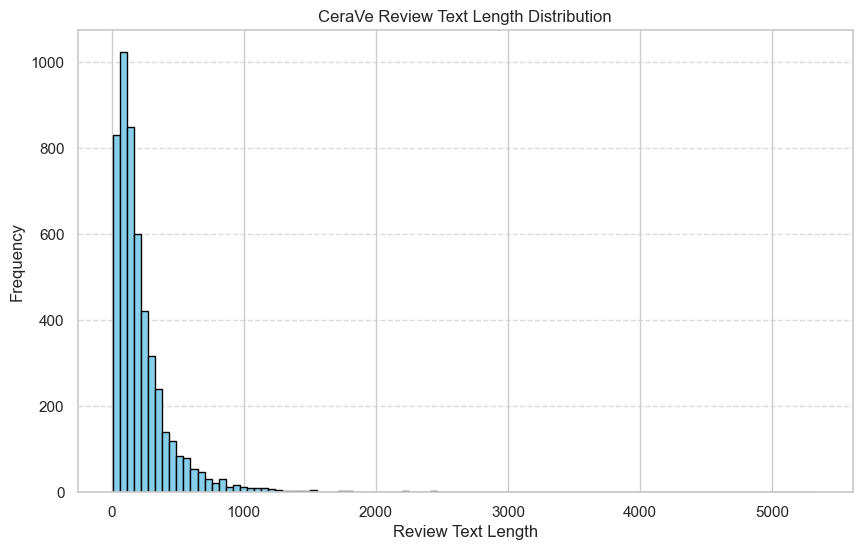

In [389]:
# CeraVe
# Filter the DataFrame for brand 'CeraVe'
df_cerave = df[df['Brand'] == 'CeraVe']

# Filter out rows with empty review text
df_cerave_filtered = df_cerave.dropna(subset=['Review Len'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_cerave_filtered['Review Len'], bins=100, color='skyblue', edgecolor='black')
plt.title('CeraVe Review Text Length Distribution')
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 6.3.2 La Roche-Posay - Review Text Length

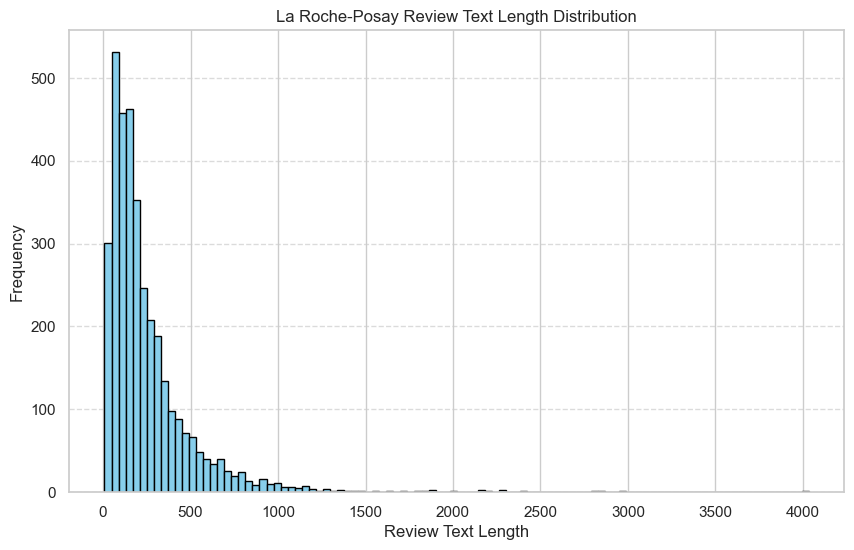

In [390]:
# La Roche-Posay
# Filter the DataFrame for brand 'La Roche-Posay'
df_lrp = df[df['Brand'] == 'La Roche-Posay']

# Filter out rows with empty review text
df_lrp_filtered = df_lrp.dropna(subset=['Review Len'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_lrp_filtered['Review Len'], bins=100, color='skyblue', edgecolor='black')
plt.title('La Roche-Posay Review Text Length Distribution')
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 7.0 Sentiment Analysis

In [4]:
# Figuring out the distribution of categories
df['Rating'].value_counts()

Rating
5    2366
1    1801
4    1581
3    1508
2    1314
Name: count, dtype: int64

In [5]:
# Deciding the outcome column (product rating) based on the overall score.
# If the score is greater than 3, we take that as high-rated rating
# If the value is less than 3 it is low-rated
# If it is equal to 3, we take that as moderate-rated rating.

def classify_rating(row):
    if row['Rating'] == 3.0:
        val = 'Moderate-rated' 
    elif row['Rating'] == 1.0 or row['Rating'] == 2.0:
        val = 'Low-rated' 
    elif row['Rating'] == 4.0 or row['Rating'] == 5.0:
        val = 'High-rated' 
    else:
        val = -1
    return val

# Applying the function in our new column
# sentiment -> rating_class
df['Rating Class'] = df.apply(classify_rating, axis=1)

In [6]:
df['Rating Class'].value_counts()

Rating Class
High-rated        3947
Low-rated         3115
Moderate-rated    1508
Name: count, dtype: int64

### Create 'Sentiment Label' Column - Classify Ratings into Sentiments

In [7]:
# Deciding the outcome column (product rating) based on the overall score.
# If the score is greater than 3, we take that as positive sentiment
# If the value is less than 3 it is negative sentiment
# If it is equal to 3, we take that as neutral sentiment.

def classify_rating(row):
    if row['Rating'] == 3.0:
        val = 'neutral' 
    elif row['Rating'] == 1.0 or row['Rating'] == 2.0:
        val = 'negative' 
    elif row['Rating'] == 4.0 or row['Rating'] == 5.0:
        val = 'positive' 
    else:
        val = -1
    return val

# Applying the function in our new column
df['Sentiment Label'] = df.apply(classify_rating, axis=1)

In [8]:
df['Sentiment Label'].value_counts()

Sentiment Label
positive    3947
negative    3115
neutral     1508
Name: count, dtype: int64

In [9]:
# Group by brand and count the occurrences of each VADER sentiment, then unstack for better readability
sentiment_label_counts_by_brand_unstacked = df.groupby('Brand')['Sentiment Label'].value_counts().unstack()

sentiment_label_counts_by_brand_unstacked

Sentiment Label,negative,neutral,positive
Brand,,,
CeraVe,1797,914,2292
La Roche-Posay,1318,594,1655


### 7.1 Pre-Trained Model - VADER

In [10]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nabila\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
def extract_score(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']

    sentiment = 'neutral'
    if compound > 0:
        sentiment = "positive"
    elif compound < 0:
        sentiment = "negative"

    return sentiment, compound

In [12]:
df['VADER Sentiment'], df['VADER Polarity Score'] = zip(*df['Lemmatized Tokens'].apply(extract_score))

In [13]:
df['VADER Sentiment'].value_counts()

VADER Sentiment
positive    4355
negative    2563
neutral     1652
Name: count, dtype: int64

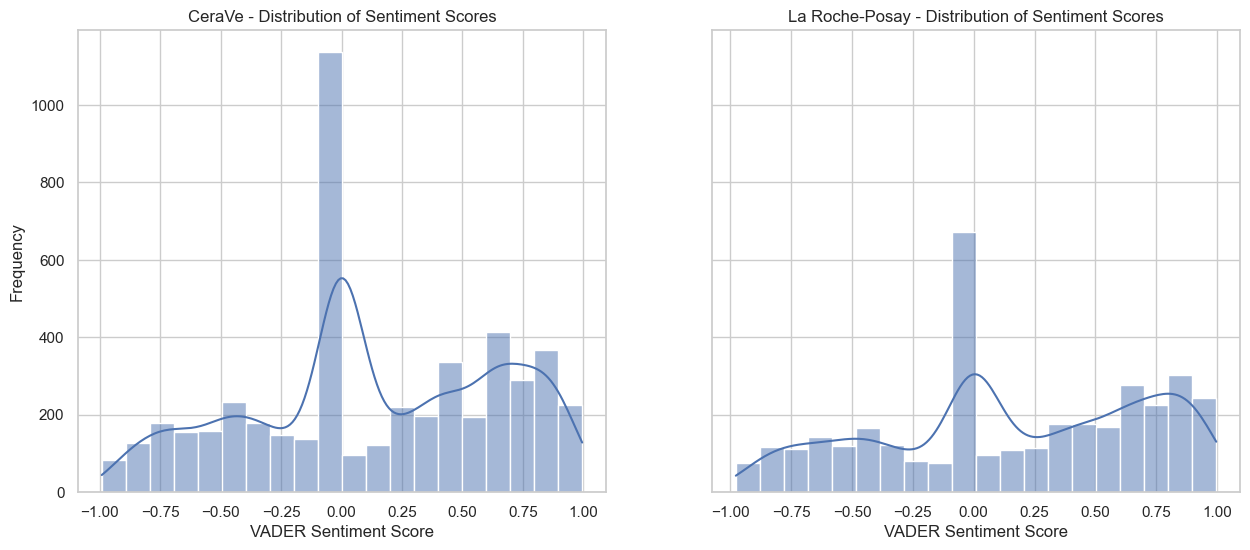

In [400]:
# Filter data for each brand
cerave_data = df[df['Brand'] == 'CeraVe']
larocheposay_data = df[df['Brand'] == 'La Roche-Posay']

# Create subplots for each brand
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Distribution of sentiment scores for CeraVe
sns.histplot(cerave_data['VADER Polarity Score'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('CeraVe - Distribution of Sentiment Scores')
axes[0].set_xlabel('VADER Sentiment Score')
axes[0].set_ylabel('Frequency')

# Distribution of sentiment scores for La Roche-Posay
sns.histplot(larocheposay_data['VADER Polarity Score'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('La Roche-Posay - Distribution of Sentiment Scores')
axes[1].set_xlabel('VADER Sentiment Score')
axes[1].set_ylabel('Frequency')

plt.show()

In [14]:
# Group by brand and count the occurrences of each VADER sentiment, then unstack for better readability
vader_sentiment_counts_by_brand_unstacked = df.groupby('Brand')['VADER Sentiment'].value_counts().unstack()

vader_sentiment_counts_by_brand_unstacked

VADER Sentiment,negative,neutral,positive
Brand,,,
CeraVe,1484,1054,2465
La Roche-Posay,1079,598,1890


In [402]:
# Calculate the percentage for each sentiment within each brand
vader_sentiment_percentages_by_brand = vader_sentiment_counts_by_brand_unstacked.div(vader_sentiment_counts_by_brand_unstacked.sum(axis=1), axis=0) * 100

vader_sentiment_percentages_by_brand.round(2)

VADER Sentiment,negative,neutral,positive
Brand,,,
CeraVe,29.66,21.07,49.27
La Roche-Posay,30.25,16.76,52.99




Classification Report (VADER Sentiment):
              precision    recall  f1-score   support

    negative       0.62      0.51      0.56      3115
     neutral       0.21      0.23      0.22      1508
    positive       0.62      0.69      0.65      3947

    accuracy                           0.54      8570
   macro avg       0.48      0.48      0.48      8570
weighted avg       0.55      0.54      0.54      8570



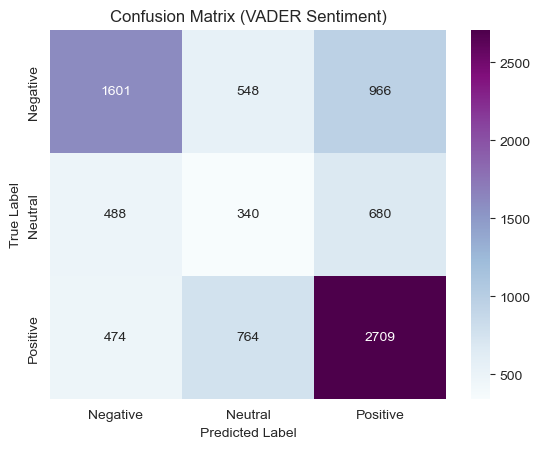

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Drop rows with NaN values in the 'VADER Sentiment' column
df.dropna(subset=['Sentiment Label'], inplace=True)

# Classification Report for VADER Sentiment
print('\n\nClassification Report (VADER Sentiment):')
print(classification_report(df['Sentiment Label'], df['VADER Sentiment'], target_names=['negative', 'neutral', 'positive']))

# Calculate confusion matrix for VADER Sentiment
conf_matrix_vader = confusion_matrix(df['Sentiment Label'], df['VADER Sentiment'])

# Plot confusion matrix for VADER Sentiment
sns.heatmap(conf_matrix_vader, annot=True, fmt='d', cmap='BuPu', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (VADER Sentiment)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

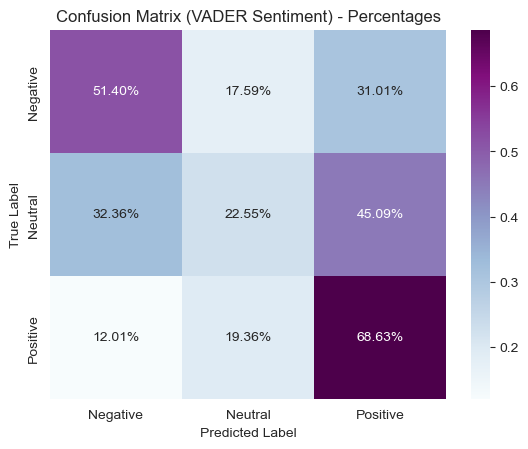

In [16]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(df['Sentiment Label'], df['VADER Sentiment'])

# Normalize the confusion matrix to get percentages
norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with percentages
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2%', cmap='BuPu', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (VADER Sentiment) - Percentages")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [17]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'MP2_all_vader.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'MP2_all_vader.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: MP2_all_vader.csv
Cleaned xlsx data has been exported to: MP2_all_vader.xlsx


### 7.2 Pre-Trained Model - TextBlob 

In [18]:
!pip install textblob
from textblob import TextBlob

In [19]:
from textblob import TextBlob

# Function to get sentiment polarity from a text
def get_sentiment_polarity(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'body' column
df['TB Polarity Score'] = df['Lemmatized Tokens'].apply(get_sentiment_polarity)

In [20]:
# Function to get sentiment label based on polarity score
def get_sentiment_label(score):
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

# Example: Apply sentiment label to the 'polarity_score' column
df['TB Sentiment'] = df['TB Polarity Score'].apply(get_sentiment_label)

In [21]:
df['TB Sentiment'].value_counts()

TB Sentiment
positive    4160
negative    2482
neutral     1928
Name: count, dtype: int64

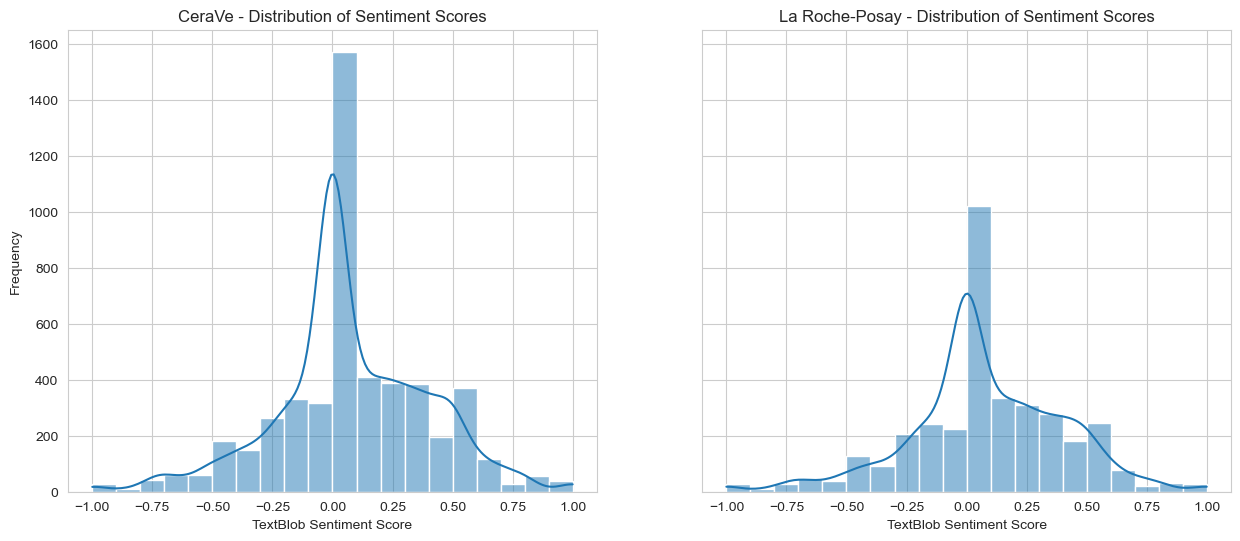

In [23]:
# Filter data for each brand
cerave_data = df[df['Brand'] == 'CeraVe']
larocheposay_data = df[df['Brand'] == 'La Roche-Posay']

# Create subplots for each brand
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Distribution of sentiment scores for CeraVe
sns.histplot(cerave_data['TB Polarity Score'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('CeraVe - Distribution of Sentiment Scores')
axes[0].set_xlabel('TextBlob Sentiment Score')
axes[0].set_ylabel('Frequency')

# Distribution of sentiment scores for La Roche-Posay
sns.histplot(larocheposay_data['TB Polarity Score'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('La Roche-Posay - Distribution of Sentiment Scores')
axes[1].set_xlabel('TextBlob Sentiment Score')
axes[1].set_ylabel('Frequency')

plt.show()

In [24]:
# Group by brand and count the occurrences of each TextBlob sentiment, then unstack for better readability
tb_sentiment_counts_by_brand_unstacked = df.groupby('Brand')['TB Sentiment'].value_counts().unstack()

tb_sentiment_counts_by_brand_unstacked

TB Sentiment,negative,neutral,positive
Brand,,,
CeraVe,1442,1186,2375
La Roche-Posay,1040,742,1785


In [25]:
# Calculate the percentage for each sentiment within each brand
tb_sentiment_percentages_by_brand = tb_sentiment_counts_by_brand_unstacked.div(tb_sentiment_counts_by_brand_unstacked.sum(axis=1), axis=0) * 100

tb_sentiment_percentages_by_brand.round(2)

TB Sentiment,negative,neutral,positive
Brand,,,
CeraVe,28.82,23.71,47.47
La Roche-Posay,29.16,20.80,50.04




Classification Report:
              precision    recall  f1-score   support

    negative       0.63      0.50      0.56      3115
     neutral       0.19      0.24      0.21      1508
    positive       0.64      0.68      0.66      3947

    accuracy                           0.54      8570
   macro avg       0.49      0.47      0.48      8570
weighted avg       0.56      0.54      0.54      8570



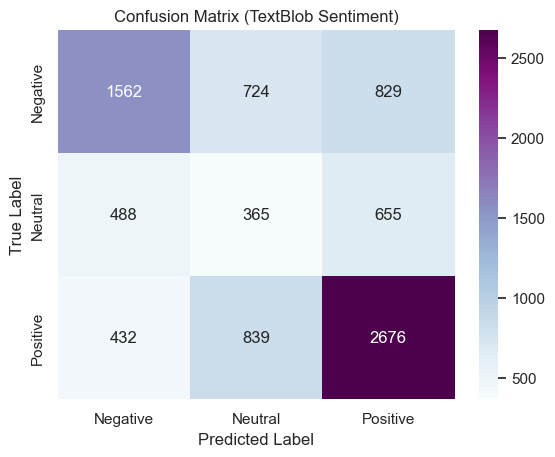

In [26]:
# Set the style
sns.set(style="whitegrid")

# Classification Report
print('\n\nClassification Report:')
print(classification_report(df['Sentiment Label'], df['TB Sentiment']))

# Calculate confusion matrix
conf_matrix = confusion_matrix(df['Sentiment Label'], df['TB Sentiment'])

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (TextBlob Sentiment)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

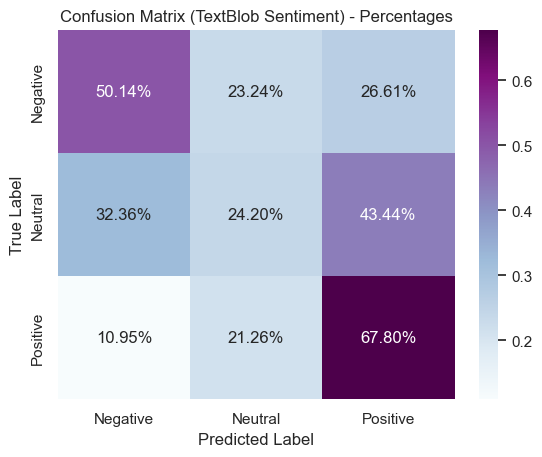

In [27]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(df['Sentiment Label'], df['TB Sentiment'])

# Normalize the confusion matrix to get percentages
norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with percentages
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2%', cmap='BuPu', 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix (TextBlob Sentiment) - Percentages")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'MP2_all_tb.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'MP2_all_tb.xlsx'

# Export the DataFrame to an Excel file
df.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: MP2_all_tb.csv
Cleaned xlsx data has been exported to: MP2_all_tb.xlsx


In [289]:
df.head()

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
0,1,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,"['i', 'bought', 'this', 'because', 'i', '’', '...","['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,Low-rated,negative,negative,-0.8696,-0.614286,negative
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated,negative,neutral,0.0000,0.300000,positive
2,1,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,Low-rated,negative,negative,-0.4767,0.170000,positive
3,1,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,Low-rated,negative,neutral,0.0000,-0.069444,negative
4,1,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,Low-rated,negative,positive,0.2273,-0.550000,negative


### Need to do copy !

In [290]:
df_with_sentiment = df.copy()

## 7.3 Using VADER's Sentiment

### Sentiment Distributions by Rating

In [291]:
# Group by rating and sentiment to count occurrences
sentiment_counts = df.groupby(['Rating', 'VADER Sentiment']).size().unstack(fill_value=0)
sentiment_counts

VADER Sentiment,negative,neutral,positive
Rating,,,
1,1039,289,473
2,562,259,493
3,488,340,680
4,267,332,982
5,207,432,1727


## 7.3.1 High-Rated (4,5) Rating: Sentiment Disributions

In [292]:
# Filter for ratings 4 and 5
ratings_4_and_5 = sentiment_counts.loc[[4.0, 5.0]]

# Display the results
ratings_4_and_5

VADER Sentiment,negative,neutral,positive
Rating,,,
4,267,332,982
5,207,432,1727


In [293]:
# Calculate the percentage of each sentiment within each rating
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Filter for ratings 4.0 and 5.0
ratings_4_and_5_percentages = sentiment_percentages.loc[[4.0, 5.0]].round(2)

# Display the results
ratings_4_and_5_percentages

VADER Sentiment,negative,neutral,positive
Rating,,,
4,16.89,21.00,62.11
5,8.75,18.26,72.99


In [294]:
# Calculate the combined counts for sentiments across ratings 4.0 and 5.0
combined_counts = sentiment_counts.loc[[4.0, 5.0]].sum()

# Calculate the total combined count
total_combined_count = combined_counts.sum()

# Calculate the combined sentiment percentages
combined_sentiment_percentages = (combined_counts / total_combined_count) * 100

# Format the combined sentiment percentages to two decimal points
combined_sentiment_percentages = combined_sentiment_percentages.round(2)
combined_sentiment_percentages

VADER Sentiment
negative    12.01
neutral     19.36
positive    68.63
dtype: float64

In [295]:
# Filter for ratings 4.0 and 5.0
ratings_4_and_5_reviews = df[df['Rating'].isin([4.0, 5.0])]

# Filter out positive sentiments
non_positive_reviews = ratings_4_and_5_reviews[ratings_4_and_5_reviews['VADER Sentiment'] != 'positive']
non_positive_reviews

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
276,4,i probably won’t repurchase this one because i...,acne and oily,CeraVe,Cleanser,140,"['i', 'probably', 'won', '’', 't', 'repurchase...","['repurchase', 'extra', 'foamy', 'switch', 've...",repurchase extra foamy switch version cereve c...,High-rated,positive,neutral,0.0000,0.0,neutral
277,4,it works… leaves my skin soft but it doesn’t f...,acne and oily,CeraVe,Cleanser,61,"['it', 'works…', 'leaves', 'my', 'skin', 'soft...","['leaves', 'soft', 'foamit']",leaf soft foamit,High-rated,positive,neutral,0.0000,0.1,positive
280,4,it arrived on time but it was so dirty from th...,acne and oily,CeraVe,Cleanser,99,"['it', 'arrived', 'on', 'time', 'but', 'it', '...","['arrived', 'dirty', 'picture', 'expiration']",arrived dirty picture expiration,High-rated,positive,negative,-0.4404,-0.6,negative
288,4,"he help my skin with complexion no regret , i ...",acne and oily,CeraVe,Cleanser,205,"['he', 'help', 'my', 'skin', 'with', 'complexi...","['complexion', 'regret', 'recommend', 'biore',...",complexion regret recommend biore cleansing ba...,High-rated,positive,negative,-0.6486,-0.6,negative
291,4,great productcerave,acne and oily,CeraVe,Cleanser,18,"['great', 'productcerave']",['productcerave'],productcerave,High-rated,positive,neutral,0.0000,0.0,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,5,this absolutely changed me skinamazing product,dry,La Roche-Posay,Serum,41,"['this', 'absolutely', 'changed', 'me', 'skina...","['absolutely', 'changed', 'skinamazing']",absolutely changed skinamazing,High-rated,positive,neutral,0.0000,0.2,positive
8557,5,felt the result after few daysreally works,dry,La Roche-Posay,Serum,36,"['felt', 'the', 'result', 'after', 'few', 'day...","['result', 'daysreally']",result daysreally,High-rated,positive,neutral,0.0000,0.0,neutral
8561,5,a little goes a long way. this serum made my f...,dry,La Roche-Posay,Serum,88,"['a', 'little', 'goes', 'a', 'long', 'way', '....","['soft', 'silky', 'matte', 'feel skin', 'smoot...",soft silky matte feel skin smoothing,High-rated,positive,neutral,0.0000,0.1,positive
8568,5,moistures and illuminates skin. put imine over...,dry,La Roche-Posay,Serum,55,"['moistures', 'and', 'illuminates', 'skin', '....","['moistures', 'illuminates', 'imine', 'ponds l...",moisture illuminates imine ponds looks,High-rated,positive,neutral,0.0000,0.0,neutral


### High-Rating Distributions by Brand

In [296]:
ratings_4_and_5_reviews['Brand'].value_counts()

Brand
CeraVe            2292
La Roche-Posay    1655
Name: count, dtype: int64

In [297]:
# Select only the specified columns
selected_columns = ['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'VADER Polarity Score', 'VADER Sentiment']
non_positive_reviews = non_positive_reviews[selected_columns]

In [298]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'VADER Sentiment/MP2_4_5_stars_non_positive_reviews.csv'

# Export the DataFrame to a CSV file
non_positive_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'VADER Sentiment/MP2_4_5_stars_non_positive_reviews.xlsx'

# Export the DataFrame to an Excel file
non_positive_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: VADER Sentiment/MP2_4_5_stars_non_positive_reviews.csv
Cleaned xlsx data has been exported to: VADER Sentiment/MP2_4_5_stars_non_positive_reviews.xlsx


## 7.3.2 Moderate-Rated (3) Rating: Sentiment Disributions

In [299]:
# Filter for ratings 3
ratings_3 = sentiment_counts.loc[3.0]

# Display the results
ratings_3

VADER Sentiment
negative    488
neutral     340
positive    680
Name: 3, dtype: int64

In [300]:
# Calculate the percentage of each sentiment within each rating
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Filter for ratings 3.0
ratings_3_percentages = sentiment_percentages.loc[3.0].round(2)

# Display the results
ratings_3_percentages

VADER Sentiment
negative    32.36
neutral     22.55
positive    45.09
Name: 3, dtype: float64

In [301]:
# Filter for ratings 3.0
ratings_3_reviews = df[df['Rating'].isin([3.0])]

# Filter out neutral sentiments
non_neutral_reviews = ratings_3_reviews[ratings_3_reviews['VADER Sentiment'] != 'neutral']
non_neutral_reviews

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
182,3,i really like cerave products. this one isnt m...,acne and oily,CeraVe,Cleanser,302,"['i', 'really', 'like', 'cerave', 'products', ...","['products', 'favorite', 'clean', 'surface', '...",product favorite clean surface soap rinseabili...,Moderate-rated,neutral,positive,0.6908,0.433333,positive
183,3,"the product itself is very good, but doesn’t a...",acne and oily,CeraVe,Cleanser,71,"['the', 'product', 'itself', 'is', 'very', 'go...","['clean', 'well it']",clean well it,Moderate-rated,neutral,positive,0.5859,0.366667,positive
184,3,"the packaging is great, it's easy to use and ...",acne and oily,CeraVe,Cleanser,147,"['the', 'packaging', 'is', 'great', ',', 'it',...","['easy', 'not', 'bathroom', 'cleans', 'not', '...",easy not bathroom clean not deeply prevent mil...,Moderate-rated,neutral,positive,0.0903,0.266667,positive
186,3,the product itself is fine but the shipping to...,acne and oily,CeraVe,Cleanser,172,"['the', 'product', 'itself', 'is', 'fine', 'bu...","['fine', 'shipping', 'days', 'maryland', 'tenn...",fine shipping day maryland tennessee usps wo n...,Moderate-rated,neutral,positive,0.3818,0.177778,positive
188,3,the pump doesn’t work.broken,acne and oily,CeraVe,Cleanser,25,"['the', 'pump', 'doesn', '’', 't', 'work.broken']",['work broken'],work broken,Moderate-rated,neutral,negative,-0.4767,-0.400000,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8505,3,i get it: some people like scented facial prod...,dry,La Roche-Posay,Serum,249,"['i', 'get', 'it', ':', 'some', 'people', 'lik...","['scented', 'products', 'lightly', 'scented', ...",scented product lightly scented misleading nic...,Moderate-rated,neutral,positive,0.8555,0.427778,positive
8507,3,i have loved this product and purchased it for...,dry,La Roche-Posay,Serum,309,"['i', 'have', 'loved', 'this', 'product', 'and...","['loved', 'rich', 'moist', 'literally', 'glow'...",loved rich moist literally glow purchase water...,Moderate-rated,neutral,positive,0.6258,0.033333,positive
8510,3,have sensitive skin and fragrance is irritatin...,dry,La Roche-Posay,Serum,89,"['have', 'sensitive', 'skin', 'and', 'fragranc...","['irritating', 'package', 'sealed strong']",irritating package sealed strong,Moderate-rated,neutral,positive,0.0772,0.016667,positive
8511,3,"therw is ni qr code, no exp.dateit was not an ...",dry,La Roche-Posay,Serum,48,"['therw', 'is', 'ni', 'qr', 'code', ',', 'no',...","['therw', 'qr', 'code', 'exp dateit', 'not', '...",therw qr code exp dateit not original item,Moderate-rated,neutral,negative,-0.2411,-0.187500,negative


In [302]:
ratings_3_reviews['Brand'].value_counts()

Brand
CeraVe            914
La Roche-Posay    594
Name: count, dtype: int64

In [303]:
# Select only the specified columns
selected_columns = ['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'VADER Polarity Score', 'VADER Sentiment']
non_neutral_reviews = non_neutral_reviews[selected_columns]

In [304]:
non_neutral_reviews

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,VADER Polarity Score,VADER Sentiment
182,3,i really like cerave products. this one isnt m...,CeraVe,"['products', 'favorite', 'clean', 'surface', '...",product favorite clean surface soap rinseabili...,0.6908,positive
183,3,"the product itself is very good, but doesn’t a...",CeraVe,"['clean', 'well it']",clean well it,0.5859,positive
184,3,"the packaging is great, it's easy to use and ...",CeraVe,"['easy', 'not', 'bathroom', 'cleans', 'not', '...",easy not bathroom clean not deeply prevent mil...,0.0903,positive
186,3,the product itself is fine but the shipping to...,CeraVe,"['fine', 'shipping', 'days', 'maryland', 'tenn...",fine shipping day maryland tennessee usps wo n...,0.3818,positive
188,3,the pump doesn’t work.broken,CeraVe,['work broken'],work broken,-0.4767,negative
...,...,...,...,...,...,...,...
8505,3,i get it: some people like scented facial prod...,La Roche-Posay,"['scented', 'products', 'lightly', 'scented', ...",scented product lightly scented misleading nic...,0.8555,positive
8507,3,i have loved this product and purchased it for...,La Roche-Posay,"['loved', 'rich', 'moist', 'literally', 'glow'...",loved rich moist literally glow purchase water...,0.6258,positive
8510,3,have sensitive skin and fragrance is irritatin...,La Roche-Posay,"['irritating', 'package', 'sealed strong']",irritating package sealed strong,0.0772,positive
8511,3,"therw is ni qr code, no exp.dateit was not an ...",La Roche-Posay,"['therw', 'qr', 'code', 'exp dateit', 'not', '...",therw qr code exp dateit not original item,-0.2411,negative


In [305]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'VADER Sentiment/MP2_3_stars_non_neutral_reviews.csv'

# Export the DataFrame to a CSV file
non_neutral_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'VADER Sentiment/MP2_3_stars_non_neutral_reviews.xlsx'

# Export the DataFrame to an Excel file
non_neutral_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: VADER Sentiment/MP2_3_stars_non_neutral_reviews.csv
Cleaned xlsx data has been exported to: VADER Sentiment/MP2_3_stars_non_neutral_reviews.xlsx


## 7.3.3 Low-Rated (1,2) Rating: Sentiment Disributions

In [306]:
# Filter for ratings 1 and 2
ratings_1_and_2 = sentiment_counts.loc[[1.0, 2.0]]

# Display the results
ratings_1_and_2

VADER Sentiment,negative,neutral,positive
Rating,,,
1,1039,289,473
2,562,259,493


In [307]:
# Calculate the percentage of each sentiment within each rating
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Filter for ratings 1.0 and 2.0
ratings_1_and_2_percentages = sentiment_percentages.loc[[1.0, 2.0]].round(2)

# Display the results
ratings_1_and_2_percentages

VADER Sentiment,negative,neutral,positive
Rating,,,
1,57.69,16.05,26.26
2,42.77,19.71,37.52


In [308]:
# Calculate the combined counts for sentiments across ratings 1.0 and 2.0
combined_counts = sentiment_counts.loc[[1.0, 2.0]].sum()

# Calculate the total combined count
total_combined_count = combined_counts.sum()

# Calculate the combined sentiment percentages
combined_sentiment_percentages = (combined_counts / total_combined_count) * 100

# Format the combined sentiment percentages to two decimal points
combined_sentiment_percentages = combined_sentiment_percentages.round(2)
combined_sentiment_percentages

VADER Sentiment
negative    51.40
neutral     17.59
positive    31.01
dtype: float64

In [309]:
# Filter for ratings 1.0 and 2.0
ratings_1_and_2_reviews = df[df['Rating'].isin([1.0, 2.0])]

# Filter out negative sentiments
non_negative_reviews = ratings_1_and_2_reviews[ratings_1_and_2_reviews['VADER Sentiment'] != 'negative']
non_negative_reviews

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated,negative,neutral,0.0000,0.300000,positive
3,1,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,Low-rated,negative,neutral,0.0000,-0.069444,negative
4,1,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,Low-rated,negative,positive,0.2273,-0.550000,negative
8,1,edit: lol i had a severe allergic reaction two...,acne and oily,CeraVe,Cleanser,928,"['edit', ':', 'lol', 'i', 'had', 'a', 'severe'...","['edit', 'lol', 'severe', 'allergic', 'reactio...",edit lol severe allergic reaction cetaphil rec...,Low-rated,negative,positive,0.8711,0.083792,positive
9,1,it doesn’t feel the same one i buy from target...,acne and oily,CeraVe,Cleanser,49,"['it', 'doesn', '’', 't', 'feel', 'the', 'same...",['targetdidn'],targetdidn,Low-rated,negative,neutral,0.0000,0.000000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498,2,"it's texture was fine, similar to my zealsea b...",dry,La Roche-Posay,Serum,328,"['it', ""'s"", 'texture', 'was', 'fine', ',', 's...","['fine', 'zealsea', 'smells', 'hairspray', 'ro...",fine zealsea smell hairspray rosatia super bad...,Low-rated,negative,positive,0.6124,0.016667,positive
8499,2,i don't recommend this if you don't like any s...,dry,La Roche-Posay,Serum,152,"['i', 'do', ""n't"", 'recommend', 'this', 'if', ...","['nt', 'recommend', 'nt', 'strong', 'storng', ...",nt recommend nt strong storng headache nt not ...,Low-rated,negative,positive,0.8442,0.433333,positive
8500,2,thought i could stand the scent but i washed i...,dry,La Roche-Posay,Serum,111,"['thought', 'i', 'could', 'stand', 'the', 'sce...","['stand', 'washed', 'hour', 'strong', 'migrain...",stand washed hour strong migraine strong,Low-rated,negative,positive,0.7650,0.433333,positive
8501,2,i bought this product because of the samples t...,dry,La Roche-Posay,Serum,229,"['i', 'bought', 'this', 'product', 'because', ...","['samples', 'office', 'samples', 'improved', '...",sample office sample improved wrinkle diminish...,Low-rated,negative,positive,0.4767,0.000000,neutral


In [310]:
ratings_1_and_2_reviews['Brand'].value_counts()

Brand
CeraVe            1797
La Roche-Posay    1318
Name: count, dtype: int64

In [311]:
# Select only the specified columns
selected_columns = ['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'VADER Polarity Score', 'VADER Sentiment']
non_negative_reviews = non_negative_reviews[selected_columns]

In [312]:
non_negative_reviews

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,VADER Polarity Score,VADER Sentiment
1,1,i don’t understand how these brand name compan...,CeraVe,"['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,0.0000,neutral
3,1,"so, you know that slime you make when you mix ...",CeraVe,"['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,0.0000,neutral
4,1,i’m writing this review to hopefully save some...,CeraVe,"['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,0.2273,positive
8,1,edit: lol i had a severe allergic reaction two...,CeraVe,"['edit', 'lol', 'severe', 'allergic', 'reactio...",edit lol severe allergic reaction cetaphil rec...,0.8711,positive
9,1,it doesn’t feel the same one i buy from target...,CeraVe,['targetdidn'],targetdidn,0.0000,neutral
...,...,...,...,...,...,...,...
8498,2,"it's texture was fine, similar to my zealsea b...",La Roche-Posay,"['fine', 'zealsea', 'smells', 'hairspray', 'ro...",fine zealsea smell hairspray rosatia super bad...,0.6124,positive
8499,2,i don't recommend this if you don't like any s...,La Roche-Posay,"['nt', 'recommend', 'nt', 'strong', 'storng', ...",nt recommend nt strong storng headache nt not ...,0.8442,positive
8500,2,thought i could stand the scent but i washed i...,La Roche-Posay,"['stand', 'washed', 'hour', 'strong', 'migrain...",stand washed hour strong migraine strong,0.7650,positive
8501,2,i bought this product because of the samples t...,La Roche-Posay,"['samples', 'office', 'samples', 'improved', '...",sample office sample improved wrinkle diminish...,0.4767,positive


In [313]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'VADER Sentiment/MP2_1_2_stars_non_negative_reviews.csv'

# Export the DataFrame to a CSV file
non_negative_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'VADER Sentiment/MP2_1_2_stars_non_negative_reviews.xlsx'

# Export the DataFrame to an Excel file
non_negative_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: VADER Sentiment/MP2_1_2_stars_non_negative_reviews.csv
Cleaned xlsx data has been exported to: VADER Sentiment/MP2_1_2_stars_non_negative_reviews.xlsx


## Rating with Correct Sentiment Reviews

In [314]:
# Define the correct sentiment conditions
positive_sentiment_conditions = (df['Rating'].isin([4.0, 5.0])) & (df['VADER Sentiment'] == 'positive')
neutral_sentiment_conditions = (df['Rating'] == 3.0) & (df['VADER Sentiment'] == 'neutral')
negative_sentiment_conditions = (df['Rating'].isin([1.0, 2.0])) & (df['VADER Sentiment'] == 'negative')

# Filter the DataFrame based on the conditions
correct_sentiment_reviews = df[positive_sentiment_conditions | neutral_sentiment_conditions | negative_sentiment_conditions]

# Select only the desired columns
correct_sentiment_reviews = correct_sentiment_reviews[['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'VADER Polarity Score', 'VADER Sentiment']]

In [315]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'VADER Sentiment/MP2_correct_sentiment_reviews.csv'

# Export the DataFrame to a CSV file
correct_sentiment_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'VADER Sentiment/MP2_correct_sentiment_reviews.xlsx'

# Export the DataFrame to an Excel file
correct_sentiment_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: VADER Sentiment/MP2_correct_sentiment_reviews.csv
Cleaned xlsx data has been exported to: VADER Sentiment/MP2_correct_sentiment_reviews.xlsx


In [414]:
# Specify the path to the concatenated file
cleaned_file_path = 'VADER Sentiment/MP2_correct_sentiment_reviews.csv'

# Load the concatenated file into a DataFrame
correct_sentiment_reviews = pd.read_csv(cleaned_file_path)

# Make a copy of raw data into a df DataFrame
df = correct_sentiment_reviews.copy()

## Feature Engineering - Feature Extraction

### TF-IDF (Term Frequency - Inverse Document Frequency)

Extracting features from cleaned reviews is a crucial step before constructing our sentiment analysis model. Computers can't comprehend words and their associated sentiments directly, so we need to convert the textual data into a numerical representation. In this project, we'll utilize the TF-IDF method for this conversion process.


In [58]:
!pip install -U scikit-learn imbalanced-learn

In [317]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
#from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB 
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve, auc

from sklearn.metrics import accuracy_score, classification_report

#Other miscellaneous libraries
from collections import Counter
# from imblearn.over_sampling import SMOTE

In [415]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
# First split: 70% train, 30% temporary (combined validation and test)
# Train-test split(from complete data)
X_train, X_temp, y_train, y_temp = train_test_split(df['Lemmatized Tokens'], df['VADER Sentiment'], 
                                                    test_size=0.3, random_state=42)

# Validation-test split (from test data)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [416]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer()  

# Fit the TF-IDF vectorizer on the training data and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data using the already fitted TF-IDF vectorizer
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

# Transform the test data using the already fitted TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shape of the transformed datasets to understand the feature space
print(f'Shape of TF-IDF transformed training data: {X_train_tfidf.shape}')
print(f'Shape of TF-IDF transformed validation data: {X_valid_tfidf.shape}')
print(f'Shape of TF-IDF transformed test data: {X_test_tfidf.shape}')

Shape of TF-IDF transformed training data: (3255, 6618)
Shape of TF-IDF transformed validation data: (697, 6618)
Shape of TF-IDF transformed test data: (698, 6618)


## 3-Sentiment (Negative, Neutral, Positive)
## MNB
### Training and Testing on Valid Data

Validation Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.76      0.83       230
     neutral       0.00      0.00      0.00        57
    positive       0.80      0.99      0.89       410

    accuracy                           0.83       697
   macro avg       0.57      0.58      0.57       697
weighted avg       0.77      0.83      0.80       697



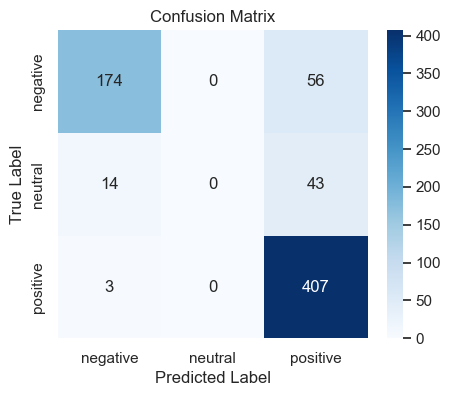

In [320]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Use Valid Data

# Initialize and train the Multinomial Naive Bayes model
nb_classifier = MultinomialNB()

# Train the model on the training data
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_valid_pred = nb_classifier.predict(X_valid_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_valid, y_valid_pred)
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV


In [321]:
from sklearn.model_selection import GridSearchCV

# Define the expanded parameter grid for MultinomialNB
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

# Create a MultinomialNB classifier object
nb_classifier_tuned = MultinomialNB()

# Initialize GridSearchCV with the MultinomialNB classifier and expanded parameter grid
grid_search_nb = GridSearchCV(nb_classifier_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_nb.fit(X_train_tfidf, y_train)

# Print the best parameters found
print("Best Parameters for MultinomialNB:", grid_search_nb.best_params_)

# Print the best cross-validation score found
print("Best Cross-validation Score for MultinomialNB:", grid_search_nb.best_score_)


Best Parameters for MultinomialNB: {'alpha': 0.7, 'fit_prior': False}
Best Cross-validation Score for MultinomialNB: 0.8608294930875576


### Improved MNB on Test Data


Test Accuracy after Hyperparameter Tuning: 0.86
Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.84      0.86      0.85       251
     neutral       0.83      0.10      0.17        52
    positive       0.86      0.95      0.90       395

    accuracy                           0.86       698
   macro avg       0.85      0.64      0.64       698
weighted avg       0.85      0.86      0.83       698



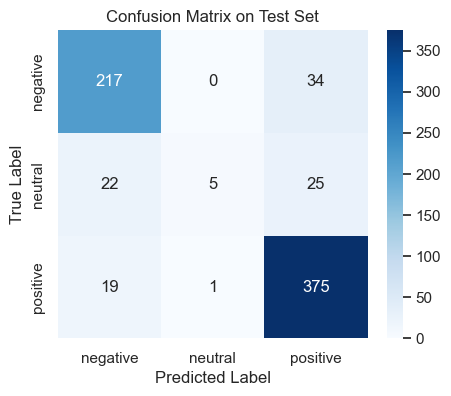

In [322]:
# Use Test Data

# Evaluate the tuned model on the test set
y_test_pred = grid_search_nb.best_estimator_.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")

# Generate a classification report for more detailed metrics
classification_rep_test = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:\n", classification_rep_test)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=grid_search_nb.best_estimator_.classes_, yticklabels=grid_search_nb.best_estimator_.classes_)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM
### Training and Testing on Valid Data 3-Sentiment


Validation Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.93      0.86       230
     neutral       1.00      0.05      0.10        57
    positive       0.90      0.95      0.93       410

    accuracy                           0.87       697
   macro avg       0.90      0.64      0.63       697
weighted avg       0.88      0.87      0.84       697



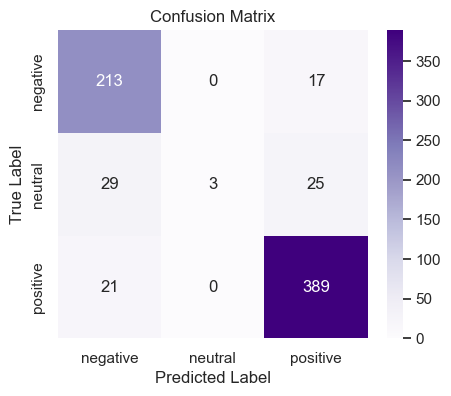

In [420]:
from sklearn.svm import SVC

# Using Valid Data

# Initialize and train the SVM classifier
svm_classifier = SVC(C=1, gamma='scale', kernel='linear') 

# Train the model on the training data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_valid_pred = svm_classifier.predict(X_valid_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_valid, y_valid_pred)
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='g', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV


In [421]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Create an SVM classifier object
svm_classifier_tuned = SVC()

# Initialize GridSearchCV with the SVM classifier and parameter grid
grid_search_svm = GridSearchCV(svm_classifier_tuned, param_grid_svm, cv=5, 
                               scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_tfidf, y_train)

# Print the best parameters found
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Print the best cross-validation score found
print("Best Cross-validation Score for SVM:", grid_search_svm.best_score_)

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Score for SVM: 0.8639016897081413


### Improved SVM on Test Data


Test Accuracy after Hyperparameter Tuning: 0.86
Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.85      0.86      0.86       251
     neutral       0.67      0.12      0.20        52
    positive       0.86      0.95      0.90       395

    accuracy                           0.86       698
   macro avg       0.79      0.64      0.65       698
weighted avg       0.84      0.86      0.84       698



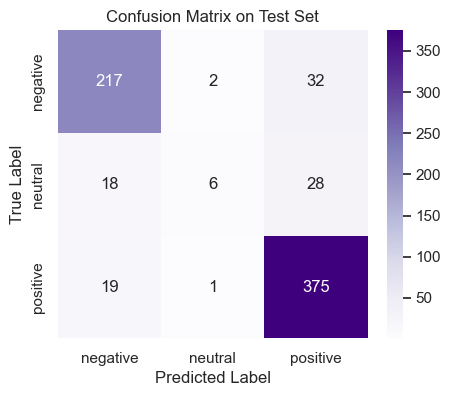

In [422]:
# Evaluate the tuned model on the test set
y_test_pred = grid_search_svm.best_estimator_.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")

# Generate a classification report for more detailed metrics
classification_rep_test = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:\n", classification_rep_test)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', xticklabels=grid_search_svm.best_estimator_.classes_, yticklabels=grid_search_svm.best_estimator_.classes_)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 7.4 Using TextBlob's Sentiment

Do copy the df1 back toget the TextBlob Sentiment

In [423]:
df_with_sentiment.head()

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
0,1,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,"['i', 'bought', 'this', 'because', 'i', '’', '...","['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,Low-rated,negative,negative,-0.8696,-0.614286,negative
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated,negative,neutral,0.0000,0.300000,positive
2,1,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,Low-rated,negative,negative,-0.4767,0.170000,positive
3,1,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,Low-rated,negative,neutral,0.0000,-0.069444,negative
4,1,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,Low-rated,negative,positive,0.2273,-0.550000,negative


In [424]:
df = df_with_sentiment.copy()

### Sentiment Distributions by Rating

In [425]:
# Group by rating and sentiment to count occurrences
sentiment_counts = df.groupby(['Rating', 'TB Sentiment']).size().unstack(fill_value=0)
sentiment_counts

TB Sentiment,negative,neutral,positive
Rating,,,
1,1016,421,364
2,546,303,465
3,488,365,655
4,242,367,972
5,190,472,1704


## 7.4.1 High-Rated (4,5) Rating: Sentiment Disributions 

In [426]:
# Filter for ratings 4 and 5
ratings_4_and_5 = sentiment_counts.loc[[4.0, 5.0]]

# Display the results
ratings_4_and_5

TB Sentiment,negative,neutral,positive
Rating,,,
4,242,367,972
5,190,472,1704


In [427]:
# Calculate the percentage of each sentiment within each rating
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Filter for ratings 4.0 and 5.0
ratings_4_and_5_percentages = sentiment_percentages.loc[[4.0, 5.0]].round(2)

# Display the results
ratings_4_and_5_percentages

TB Sentiment,negative,neutral,positive
Rating,,,
4,15.31,23.21,61.48
5,8.03,19.95,72.02


In [428]:
# Calculate the combined counts for sentiments across ratings 4.0 and 5.0
combined_counts = sentiment_counts.loc[[4.0, 5.0]].sum()

# Calculate the total combined count
total_combined_count = combined_counts.sum()

# Calculate the combined sentiment percentages
combined_sentiment_percentages = (combined_counts / total_combined_count) * 100

# Format the combined sentiment percentages to two decimal points
combined_sentiment_percentages = combined_sentiment_percentages.round(2)
combined_sentiment_percentages

TB Sentiment
negative    10.95
neutral     21.26
positive    67.80
dtype: float64

In [429]:
# Filter for ratings 4.0 and 5.0
ratings_4_and_5_reviews = df[df['Rating'].isin([4.0, 5.0])]

# Filter out positive sentiments
non_positive_reviews = ratings_4_and_5_reviews[ratings_4_and_5_reviews['TB Sentiment'] != 'positive']
non_positive_reviews

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
276,4,i probably won’t repurchase this one because i...,acne and oily,CeraVe,Cleanser,140,"['i', 'probably', 'won', '’', 't', 'repurchase...","['repurchase', 'extra', 'foamy', 'switch', 've...",repurchase extra foamy switch version cereve c...,High-rated,positive,neutral,0.0000,0.000000,neutral
280,4,it arrived on time but it was so dirty from th...,acne and oily,CeraVe,Cleanser,99,"['it', 'arrived', 'on', 'time', 'but', 'it', '...","['arrived', 'dirty', 'picture', 'expiration']",arrived dirty picture expiration,High-rated,positive,negative,-0.4404,-0.600000,negative
287,4,i typically use cetaphil dermacontrol but want...,acne and oily,CeraVe,Cleanser,214,"['i', 'typically', 'use', 'cetaphil', 'dermaco...","['typically', 'cetaphil', 'dermacontrol', 'ton...",typically cetaphil dermacontrol ton pumped han...,High-rated,positive,positive,0.4939,-0.166667,negative
288,4,"he help my skin with complexion no regret , i ...",acne and oily,CeraVe,Cleanser,205,"['he', 'help', 'my', 'skin', 'with', 'complexi...","['complexion', 'regret', 'recommend', 'biore',...",complexion regret recommend biore cleansing ba...,High-rated,positive,negative,-0.6486,-0.600000,negative
291,4,great productcerave,acne and oily,CeraVe,Cleanser,18,"['great', 'productcerave']",['productcerave'],productcerave,High-rated,positive,neutral,0.0000,0.000000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8548,5,it's goodgreat,dry,La Roche-Posay,Serum,13,"['it', ""'s"", 'goodgreat']",['goodgreat'],goodgreat,High-rated,positive,neutral,0.0000,0.000000,neutral
8551,5,i still feel the moisture on my face in the mo...,dry,La Roche-Posay,Serum,182,"['i', 'still', 'feel', 'the', 'moisture', 'on'...","['bed', 'unscented', 'worth', 'buying', 'again...",bed unscented worth buying again crazy stick,High-rated,positive,negative,-0.1280,-0.150000,negative
8557,5,felt the result after few daysreally works,dry,La Roche-Posay,Serum,36,"['felt', 'the', 'result', 'after', 'few', 'day...","['result', 'daysreally']",result daysreally,High-rated,positive,neutral,0.0000,0.000000,neutral
8568,5,moistures and illuminates skin. put imine over...,dry,La Roche-Posay,Serum,55,"['moistures', 'and', 'illuminates', 'skin', '....","['moistures', 'illuminates', 'imine', 'ponds l...",moisture illuminates imine ponds looks,High-rated,positive,neutral,0.0000,0.000000,neutral


### High-Rating Distributions by Brand

In [430]:
ratings_4_and_5_reviews['Brand'].value_counts()

Brand
CeraVe            2292
La Roche-Posay    1655
Name: count, dtype: int64

In [431]:
# Select only the specified columns
selected_columns = ['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'TB Polarity Score', 'TB Sentiment']
non_positive_reviews = non_positive_reviews[selected_columns]

In [432]:
non_positive_reviews

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,TB Polarity Score,TB Sentiment
276,4,i probably won’t repurchase this one because i...,CeraVe,"['repurchase', 'extra', 'foamy', 'switch', 've...",repurchase extra foamy switch version cereve c...,0.000000,neutral
280,4,it arrived on time but it was so dirty from th...,CeraVe,"['arrived', 'dirty', 'picture', 'expiration']",arrived dirty picture expiration,-0.600000,negative
287,4,i typically use cetaphil dermacontrol but want...,CeraVe,"['typically', 'cetaphil', 'dermacontrol', 'ton...",typically cetaphil dermacontrol ton pumped han...,-0.166667,negative
288,4,"he help my skin with complexion no regret , i ...",CeraVe,"['complexion', 'regret', 'recommend', 'biore',...",complexion regret recommend biore cleansing ba...,-0.600000,negative
291,4,great productcerave,CeraVe,['productcerave'],productcerave,0.000000,neutral
...,...,...,...,...,...,...,...
8548,5,it's goodgreat,La Roche-Posay,['goodgreat'],goodgreat,0.000000,neutral
8551,5,i still feel the moisture on my face in the mo...,La Roche-Posay,"['bed', 'unscented', 'worth', 'buying', 'again...",bed unscented worth buying again crazy stick,-0.150000,negative
8557,5,felt the result after few daysreally works,La Roche-Posay,"['result', 'daysreally']",result daysreally,0.000000,neutral
8568,5,moistures and illuminates skin. put imine over...,La Roche-Posay,"['moistures', 'illuminates', 'imine', 'ponds l...",moisture illuminates imine ponds looks,0.000000,neutral


In [337]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'TB Sentiment/MP2_4_5_stars_non_positive_reviews.csv'

# Export the DataFrame to a CSV file
non_positive_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'TB Sentiment/MP2_4_5_stars_non_positive_reviews.xlsx'

# Export the DataFrame to an Excel file
non_positive_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: TB Sentiment/MP2_4_5_stars_non_positive_reviews.csv
Cleaned xlsx data has been exported to: TB Sentiment/MP2_4_5_stars_non_positive_reviews.xlsx


## 7.4.2 Moderate-Rated (3) Rating: Sentiment Disributions 

In [433]:
# Filter for ratings 3
ratings_3 = sentiment_counts.loc[3.0]

# Display the results
ratings_3

TB Sentiment
negative    488
neutral     365
positive    655
Name: 3, dtype: int64

In [434]:
# Calculate the percentage of each sentiment within each rating
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Filter for ratings 3.0
ratings_3_percentages = sentiment_percentages.loc[3.0].round(2)

# Display the results
ratings_3_percentages

TB Sentiment
negative    32.36
neutral     24.20
positive    43.44
Name: 3, dtype: float64

In [435]:
# Filter for ratings 3.0
ratings_3_reviews = df[df['Rating'].isin([3.0])]

# Filter out neutral sentiments
non_neutral_reviews = ratings_3_reviews[ratings_3_reviews['TB Sentiment'] != 'neutral']
non_neutral_reviews

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
182,3,i really like cerave products. this one isnt m...,acne and oily,CeraVe,Cleanser,302,"['i', 'really', 'like', 'cerave', 'products', ...","['products', 'favorite', 'clean', 'surface', '...",product favorite clean surface soap rinseabili...,Moderate-rated,neutral,positive,0.6908,0.433333,positive
183,3,"the product itself is very good, but doesn’t a...",acne and oily,CeraVe,Cleanser,71,"['the', 'product', 'itself', 'is', 'very', 'go...","['clean', 'well it']",clean well it,Moderate-rated,neutral,positive,0.5859,0.366667,positive
184,3,"the packaging is great, it's easy to use and ...",acne and oily,CeraVe,Cleanser,147,"['the', 'packaging', 'is', 'great', ',', 'it',...","['easy', 'not', 'bathroom', 'cleans', 'not', '...",easy not bathroom clean not deeply prevent mil...,Moderate-rated,neutral,positive,0.0903,0.266667,positive
186,3,the product itself is fine but the shipping to...,acne and oily,CeraVe,Cleanser,172,"['the', 'product', 'itself', 'is', 'fine', 'bu...","['fine', 'shipping', 'days', 'maryland', 'tenn...",fine shipping day maryland tennessee usps wo n...,Moderate-rated,neutral,positive,0.3818,0.177778,positive
187,3,i been using this cleanser for a few months no...,acne and oily,CeraVe,Cleanser,336,"['i', 'been', 'using', 'this', 'cleanser', 'fo...","['months', 'nt', 'prefer', 'inisfree', 'roche'...",month nt prefer inisfree roche posay corxs sho...,Moderate-rated,neutral,neutral,0.0000,0.166667,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8507,3,i have loved this product and purchased it for...,dry,La Roche-Posay,Serum,309,"['i', 'have', 'loved', 'this', 'product', 'and...","['loved', 'rich', 'moist', 'literally', 'glow'...",loved rich moist literally glow purchase water...,Moderate-rated,neutral,positive,0.6258,0.033333,positive
8509,3,box was opened and appeared used. don't know a...,dry,La Roche-Posay,Serum,93,"['box', 'was', 'opened', 'and', 'appeared', 'u...","['appeared', 'nt', 'happened', 'frequently used']",appeared nt happened frequently used,Moderate-rated,neutral,neutral,0.0000,0.100000,positive
8510,3,have sensitive skin and fragrance is irritatin...,dry,La Roche-Posay,Serum,89,"['have', 'sensitive', 'skin', 'and', 'fragranc...","['irritating', 'package', 'sealed strong']",irritating package sealed strong,Moderate-rated,neutral,positive,0.0772,0.016667,positive
8511,3,"therw is ni qr code, no exp.dateit was not an ...",dry,La Roche-Posay,Serum,48,"['therw', 'is', 'ni', 'qr', 'code', ',', 'no',...","['therw', 'qr', 'code', 'exp dateit', 'not', '...",therw qr code exp dateit not original item,Moderate-rated,neutral,negative,-0.2411,-0.187500,negative


In [436]:
ratings_3_reviews['Brand'].value_counts()

Brand
CeraVe            914
La Roche-Posay    594
Name: count, dtype: int64

In [437]:
# Select only the specified columns
selected_columns = ['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'TB Polarity Score', 'TB Sentiment']
non_neutral_reviews = non_neutral_reviews[selected_columns]

In [438]:
non_neutral_reviews

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,TB Polarity Score,TB Sentiment
182,3,i really like cerave products. this one isnt m...,CeraVe,"['products', 'favorite', 'clean', 'surface', '...",product favorite clean surface soap rinseabili...,0.433333,positive
183,3,"the product itself is very good, but doesn’t a...",CeraVe,"['clean', 'well it']",clean well it,0.366667,positive
184,3,"the packaging is great, it's easy to use and ...",CeraVe,"['easy', 'not', 'bathroom', 'cleans', 'not', '...",easy not bathroom clean not deeply prevent mil...,0.266667,positive
186,3,the product itself is fine but the shipping to...,CeraVe,"['fine', 'shipping', 'days', 'maryland', 'tenn...",fine shipping day maryland tennessee usps wo n...,0.177778,positive
187,3,i been using this cleanser for a few months no...,CeraVe,"['months', 'nt', 'prefer', 'inisfree', 'roche'...",month nt prefer inisfree roche posay corxs sho...,0.166667,positive
...,...,...,...,...,...,...,...
8507,3,i have loved this product and purchased it for...,La Roche-Posay,"['loved', 'rich', 'moist', 'literally', 'glow'...",loved rich moist literally glow purchase water...,0.033333,positive
8509,3,box was opened and appeared used. don't know a...,La Roche-Posay,"['appeared', 'nt', 'happened', 'frequently used']",appeared nt happened frequently used,0.100000,positive
8510,3,have sensitive skin and fragrance is irritatin...,La Roche-Posay,"['irritating', 'package', 'sealed strong']",irritating package sealed strong,0.016667,positive
8511,3,"therw is ni qr code, no exp.dateit was not an ...",La Roche-Posay,"['therw', 'qr', 'code', 'exp dateit', 'not', '...",therw qr code exp dateit not original item,-0.187500,negative


In [344]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'TB Sentiment/MP2_3_stars_non_neutral_reviews.csv'

# Export the DataFrame to a CSV file
non_neutral_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'TB Sentiment/MP2_3_stars_non_neutral_reviews.xlsx'

# Export the DataFrame to an Excel file
non_neutral_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: TB Sentiment/MP2_3_stars_non_neutral_reviews.csv
Cleaned xlsx data has been exported to: TB Sentiment/MP2_3_stars_non_neutral_reviews.xlsx


## 7.4.3 Low-Rated (1,2) Rating: Sentiment Disributions 

In [439]:
# Filter for ratings 1 and 2
ratings_1_and_2 = sentiment_counts.loc[[1.0, 2.0]]

# Display the results
ratings_1_and_2

TB Sentiment,negative,neutral,positive
Rating,,,
1,1016,421,364
2,546,303,465


In [440]:
# Calculate the percentage of each sentiment within each rating
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Filter for ratings 1.0 and 2.0
ratings_1_and_2_percentages = sentiment_percentages.loc[[1.0, 2.0]].round(2)

# Display the results
ratings_1_and_2_percentages

TB Sentiment,negative,neutral,positive
Rating,,,
1,56.41,23.38,20.21
2,41.55,23.06,35.39


In [441]:
# Calculate the combined counts for sentiments across ratings 1.0 and 2.0
combined_counts = sentiment_counts.loc[[1.0, 2.0]].sum()

# Calculate the total combined count
total_combined_count = combined_counts.sum()

# Calculate the combined sentiment percentages
combined_sentiment_percentages = (combined_counts / total_combined_count) * 100

# Format the combined sentiment percentages to two decimal points
combined_sentiment_percentages = combined_sentiment_percentages.round(2)
combined_sentiment_percentages

TB Sentiment
negative    50.14
neutral     23.24
positive    26.61
dtype: float64

In [442]:
# Filter for ratings 1.0 and 2.0
ratings_1_and_2_reviews = df[df['Rating'].isin([1.0, 2.0])]

# Filter out negative sentiments
non_negative_reviews = ratings_1_and_2_reviews[ratings_1_and_2_reviews['TB Sentiment'] != 'negative']
non_negative_reviews

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated,negative,neutral,0.0000,0.300000,positive
2,1,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,Low-rated,negative,negative,-0.4767,0.170000,positive
5,1,i’m highly against animal cruelty and if only ...,acne and oily,CeraVe,Cleanser,289,"['i', '’', 'm', 'highly', 'against', 'animal',...","['highly', 'animal', 'cruelty', 'cruelty', 'no...",highly animal cruelty cruelty not hyped tbh no...,Low-rated,negative,negative,-0.7599,0.032000,positive
8,1,edit: lol i had a severe allergic reaction two...,acne and oily,CeraVe,Cleanser,928,"['edit', ':', 'lol', 'i', 'had', 'a', 'severe'...","['edit', 'lol', 'severe', 'allergic', 'reactio...",edit lol severe allergic reaction cetaphil rec...,Low-rated,negative,positive,0.8711,0.083792,positive
9,1,it doesn’t feel the same one i buy from target...,acne and oily,CeraVe,Cleanser,49,"['it', 'doesn', '’', 't', 'feel', 'the', 'same...",['targetdidn'],targetdidn,Low-rated,negative,neutral,0.0000,0.000000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498,2,"it's texture was fine, similar to my zealsea b...",dry,La Roche-Posay,Serum,328,"['it', ""'s"", 'texture', 'was', 'fine', ',', 's...","['fine', 'zealsea', 'smells', 'hairspray', 'ro...",fine zealsea smell hairspray rosatia super bad...,Low-rated,negative,positive,0.6124,0.016667,positive
8499,2,i don't recommend this if you don't like any s...,dry,La Roche-Posay,Serum,152,"['i', 'do', ""n't"", 'recommend', 'this', 'if', ...","['nt', 'recommend', 'nt', 'strong', 'storng', ...",nt recommend nt strong storng headache nt not ...,Low-rated,negative,positive,0.8442,0.433333,positive
8500,2,thought i could stand the scent but i washed i...,dry,La Roche-Posay,Serum,111,"['thought', 'i', 'could', 'stand', 'the', 'sce...","['stand', 'washed', 'hour', 'strong', 'migrain...",stand washed hour strong migraine strong,Low-rated,negative,positive,0.7650,0.433333,positive
8501,2,i bought this product because of the samples t...,dry,La Roche-Posay,Serum,229,"['i', 'bought', 'this', 'product', 'because', ...","['samples', 'office', 'samples', 'improved', '...",sample office sample improved wrinkle diminish...,Low-rated,negative,positive,0.4767,0.000000,neutral


In [443]:
ratings_1_and_2_reviews['Brand'].value_counts()

Brand
CeraVe            1797
La Roche-Posay    1318
Name: count, dtype: int64

In [444]:
# Select only the specified columns
selected_columns = ['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'TB Polarity Score', 'TB Sentiment']
non_negative_reviews = non_negative_reviews[selected_columns]

In [445]:
non_negative_reviews

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,TB Polarity Score,TB Sentiment
1,1,i don’t understand how these brand name compan...,CeraVe,"['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,0.300000,positive
2,1,bought this for my child to use as a face wash...,CeraVe,"['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,0.170000,positive
5,1,i’m highly against animal cruelty and if only ...,CeraVe,"['highly', 'animal', 'cruelty', 'cruelty', 'no...",highly animal cruelty cruelty not hyped tbh no...,0.032000,positive
8,1,edit: lol i had a severe allergic reaction two...,CeraVe,"['edit', 'lol', 'severe', 'allergic', 'reactio...",edit lol severe allergic reaction cetaphil rec...,0.083792,positive
9,1,it doesn’t feel the same one i buy from target...,CeraVe,['targetdidn'],targetdidn,0.000000,neutral
...,...,...,...,...,...,...,...
8498,2,"it's texture was fine, similar to my zealsea b...",La Roche-Posay,"['fine', 'zealsea', 'smells', 'hairspray', 'ro...",fine zealsea smell hairspray rosatia super bad...,0.016667,positive
8499,2,i don't recommend this if you don't like any s...,La Roche-Posay,"['nt', 'recommend', 'nt', 'strong', 'storng', ...",nt recommend nt strong storng headache nt not ...,0.433333,positive
8500,2,thought i could stand the scent but i washed i...,La Roche-Posay,"['stand', 'washed', 'hour', 'strong', 'migrain...",stand washed hour strong migraine strong,0.433333,positive
8501,2,i bought this product because of the samples t...,La Roche-Posay,"['samples', 'office', 'samples', 'improved', '...",sample office sample improved wrinkle diminish...,0.000000,neutral


In [352]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'TB Sentiment/MP2_1_2_stars_non_negative_reviews.csv'

# Export the DataFrame to a CSV file
non_negative_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'TB Sentiment/MP2_1_2_stars_non_negative_reviews.xlsx'

# Export the DataFrame to an Excel file
non_negative_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: TB Sentiment/MP2_1_2_stars_non_negative_reviews.csv
Cleaned xlsx data has been exported to: TB Sentiment/MP2_1_2_stars_non_negative_reviews.xlsx


## Rating with Correct Sentiment Reviews

In [446]:
# Define the correct sentiment conditions
positive_sentiment_conditions = (df['Rating'].isin([4.0, 5.0])) & (df['TB Sentiment'] == 'positive')
neutral_sentiment_conditions = (df['Rating'] == 3.0) & (df['TB Sentiment'] == 'neutral')
negative_sentiment_conditions = (df['Rating'].isin([1.0, 2.0])) & (df['TB Sentiment'] == 'negative')

# Filter the DataFrame based on the conditions
correct_sentiment_reviews = df[positive_sentiment_conditions | neutral_sentiment_conditions | negative_sentiment_conditions]

# Select only the desired columns
correct_sentiment_reviews = correct_sentiment_reviews[['Rating', 'Review', 'Brand', 'NoStopW Tokens', 'Lemmatized Tokens', 'TB Polarity Score', 'TB Sentiment']]

In [447]:
correct_sentiment_reviews

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,TB Polarity Score,TB Sentiment
0,1,i bought this because i’ve had really oily ski...,CeraVe,"['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,-0.614286,negative
3,1,"so, you know that slime you make when you mix ...",CeraVe,"['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,-0.069444,negative
4,1,i’m writing this review to hopefully save some...,CeraVe,"['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,-0.550000,negative
6,1,"the product looks like it was used, it was dir...",CeraVe,"['dirty', 'hair bad']",dirty hair bad,-0.650000,negative
7,1,made his pimples worst more painful he figured...,CeraVe,"['pimples', 'worst', 'painful', 'figured', 'wo...",pimple worst painful figured worse idk named s...,-0.820000,negative
...,...,...,...,...,...,...,...
8563,5,started using it for about 2 months already in...,La Roche-Posay,"['months', 'mornings', 'amazing', 'wearing', '...",month morning amazing wearing foundation flawl...,0.727778,positive
8564,5,"i used it for awhile , it really help my skin ...",La Roche-Posay,"['awhile', 'nicer', 'smoother nice']",awhile nicer smoother nice,0.600000,positive
8565,5,i enjoy using this product! using it after moi...,La Roche-Posay,"['enjoy', 'love', 'healthcare', 'journey face']",enjoy love healthcare journey face,0.450000,positive
8566,5,the media could not be loaded.\n ...,La Roche-Posay,"['media', 'not', 'loaded', 'absolute', 'favori...",medium not loaded absolute favorite light abso...,0.469444,positive


In [355]:
# FOR CSV
# Define the path where the cleaned DataFrame want to be saved
output_path = 'TB Sentiment/MP2_correct_sentiment_reviews.csv'

# Export the DataFrame to a CSV file
correct_sentiment_reviews.to_csv(output_path, index=False)

# Display the exported path
print(f"Cleaned csv data has been exported to: {output_path}")

# FOR XLSX
# Define the path where the cleaned DataFrame wants to be saved
output_path = 'TB Sentiment/MP2_correct_sentiment_reviews.xlsx'

# Export the DataFrame to an Excel file
correct_sentiment_reviews.to_excel(output_path, index=False)

# Display the exported path
print(f"Cleaned xlsx data has been exported to: {output_path}")

Cleaned csv data has been exported to: TB Sentiment/MP2_correct_sentiment_reviews.csv
Cleaned xlsx data has been exported to: TB Sentiment/MP2_correct_sentiment_reviews.xlsx


In [356]:
df.head()

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label,VADER Sentiment,VADER Polarity Score,TB Polarity Score,TB Sentiment
0,1,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,"['i', 'bought', 'this', 'because', 'i', '’', '...","['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,Low-rated,negative,negative,-0.8696,-0.614286,negative
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated,negative,neutral,0.0000,0.300000,positive
2,1,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,Low-rated,negative,negative,-0.4767,0.170000,positive
3,1,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,Low-rated,negative,neutral,0.0000,-0.069444,negative
4,1,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,Low-rated,negative,positive,0.2273,-0.550000,negative


In [448]:
df2_whole = df.copy()

In [ ]:
df = df2_whole.copy()

In [449]:
# Specify the path to the concatenated file
cleaned_file_path = 'TB Sentiment/MP2_correct_sentiment_reviews.csv'

# Load the concatenated file into a DataFrame
correct_sentiment_reviews = pd.read_csv(cleaned_file_path)

# Make a copy of raw data into a df DataFrame
df = correct_sentiment_reviews.copy()

In [450]:
df

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,TB Polarity Score,TB Sentiment
0,1,i bought this because i’ve had really oily ski...,CeraVe,"['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,-0.614286,negative
1,1,"so, you know that slime you make when you mix ...",CeraVe,"['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,-0.069444,negative
2,1,i’m writing this review to hopefully save some...,CeraVe,"['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,-0.550000,negative
3,1,"the product looks like it was used, it was dir...",CeraVe,"['dirty', 'hair bad']",dirty hair bad,-0.650000,negative
4,1,made his pimples worst more painful he figured...,CeraVe,"['pimples', 'worst', 'painful', 'figured', 'wo...",pimple worst painful figured worse idk named s...,-0.820000,negative
...,...,...,...,...,...,...,...
4598,5,started using it for about 2 months already in...,La Roche-Posay,"['months', 'mornings', 'amazing', 'wearing', '...",month morning amazing wearing foundation flawl...,0.727778,positive
4599,5,"i used it for awhile , it really help my skin ...",La Roche-Posay,"['awhile', 'nicer', 'smoother nice']",awhile nicer smoother nice,0.600000,positive
4600,5,i enjoy using this product! using it after moi...,La Roche-Posay,"['enjoy', 'love', 'healthcare', 'journey face']",enjoy love healthcare journey face,0.450000,positive
4601,5,the media could not be loaded.\n ...,La Roche-Posay,"['media', 'not', 'loaded', 'absolute', 'favori...",medium not loaded absolute favorite light abso...,0.469444,positive


In [451]:
df.shape

(4603, 7)

In [452]:
df['TB Sentiment'].value_counts()

TB Sentiment
positive    2676
negative    1562
neutral      365
Name: count, dtype: int64

## Feature Engineering - Feature Extraction

### TF-IDF (Term Frequency - Inverse Document Frequency)


In [453]:
df.head()

,Rating,Review,Brand,NoStopW Tokens,Lemmatized Tokens,TB Polarity Score,TB Sentiment
0,1,i bought this because i’ve had really oily ski...,CeraVe,"['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,-0.614286,negative
1,1,"so, you know that slime you make when you mix ...",CeraVe,"['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,-0.069444,negative
2,1,i’m writing this review to hopefully save some...,CeraVe,"['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,-0.550000,negative
3,1,"the product looks like it was used, it was dir...",CeraVe,"['dirty', 'hair bad']",dirty hair bad,-0.650000,negative
4,1,made his pimples worst more painful he figured...,CeraVe,"['pimples', 'worst', 'painful', 'figured', 'wo...",pimple worst painful figured worse idk named s...,-0.820000,negative


## 3-Sentiment (Negative, Neutral, Positive)

In [454]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
# First split: 70% train, 30% temporary (combined validation and test)
# Train-test split(from complete data)
X_train, X_temp, y_train, y_temp = train_test_split(df['Lemmatized Tokens'], df['TB Sentiment'], test_size=0.3, random_state=42)

# Validation-test split (from test data)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [455]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer()  

# Fit the TF-IDF vectorizer on the training data and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data using the already fitted TF-IDF vectorizer
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

# Transform the test data using the already fitted TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shape of the transformed datasets to understand the feature space
print(f'Shape of TF-IDF transformed training data: {X_train_tfidf.shape}')
print(f'Shape of TF-IDF transformed validation data: {X_valid_tfidf.shape}')
print(f'Shape of TF-IDF transformed test data: {X_test_tfidf.shape}')

Shape of TF-IDF transformed training data: (3222, 6408)
Shape of TF-IDF transformed validation data: (690, 6408)
Shape of TF-IDF transformed test data: (691, 6408)


## MNB

### Valid Data 3-Sentiment

Validation Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.75      0.83       244
     neutral       0.00      0.00      0.00        42
    positive       0.81      0.99      0.89       404

    accuracy                           0.84       690
   macro avg       0.58      0.58      0.57       690
weighted avg       0.80      0.84      0.82       690



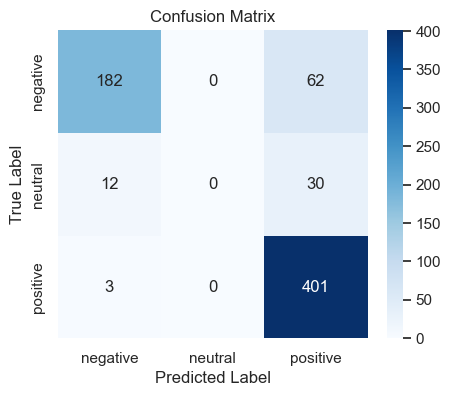

In [365]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Use Valid Data

# Initialize and train the Multinomial Naive Bayes model
nb_classifier = MultinomialNB()

# Train the model on the training data
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_valid_pred = nb_classifier.predict(X_valid_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_valid, y_valid_pred)
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [366]:
from sklearn.model_selection import GridSearchCV

# Define the expanded parameter grid for MultinomialNB
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

# Create a MultinomialNB classifier object
nb_classifier_tuned = MultinomialNB()

# Initialize GridSearchCV with the MultinomialNB classifier and expanded parameter grid
grid_search_nb = GridSearchCV(nb_classifier_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_nb.fit(X_train_tfidf, y_train)

# Print the best parameters found
print("Best Parameters for MultinomialNB:", grid_search_nb.best_params_)

# Print the best cross-validation score found
print("Best Cross-validation Score for MultinomialNB:", grid_search_nb.best_score_)


Best Parameters for MultinomialNB: {'alpha': 1.0, 'fit_prior': False}
Best Cross-validation Score for MultinomialNB: 0.8677856420626895


### Improved MNB on Test Data

Test Accuracy after Hyperparameter Tuning: 0.83
Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.80      0.87      0.83       239
     neutral       1.00      0.04      0.08        69
    positive       0.84      0.95      0.89       383

    accuracy                           0.83       691
   macro avg       0.88      0.62      0.60       691
weighted avg       0.84      0.83      0.79       691



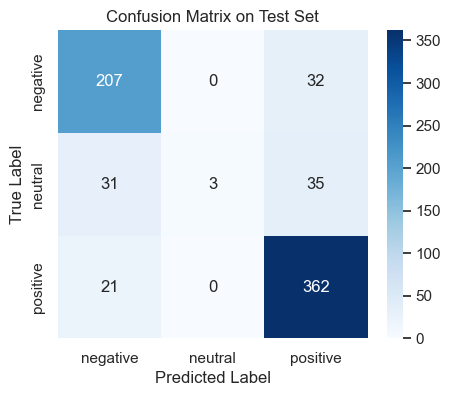

In [367]:
# Use Test Data

# Evaluate the tuned model on the test set
y_test_pred = grid_search_nb.best_estimator_.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")

# Generate a classification report for more detailed metrics
classification_rep_test = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:\n", classification_rep_test)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', 
            xticklabels=grid_search_nb.best_estimator_.classes_, 
            yticklabels=grid_search_nb.best_estimator_.classes_)

plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM

### Valid Data 3-Sentiment

Validation Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.93      0.89       244
     neutral       0.80      0.10      0.17        42
    positive       0.92      0.96      0.94       404

    accuracy                           0.89       690
   macro avg       0.86      0.66      0.67       690
weighted avg       0.89      0.89      0.87       690



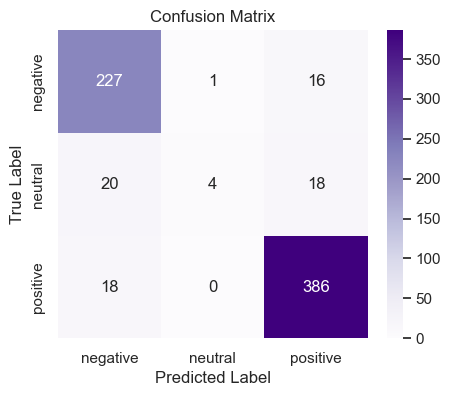

In [456]:
from sklearn.svm import SVC

# Using Valid Data

# Initialize and train the SVM classifier
svm_classifier = SVC(C=1, gamma='scale', kernel='linear') 

# Train the model on the training data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_valid_pred = svm_classifier.predict(X_valid_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_valid, y_valid_pred)
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='g', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [457]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Create an SVM classifier object
svm_classifier_tuned = SVC()

# Initialize GridSearchCV with the SVM classifier and parameter grid
grid_search_svm = GridSearchCV(svm_classifier_tuned, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_tfidf, y_train)

# Print the best parameters found
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Print the best cross-validation score found
print("Best Cross-validation Score for SVM:", grid_search_svm.best_score_)

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-validation Score for SVM: 0.881741056382108


Test Accuracy after Hyperparameter Tuning: 0.86
Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.84      0.85      0.84       239
     neutral       0.63      0.45      0.53        69
    positive       0.89      0.94      0.91       383

    accuracy                           0.86       691
   macro avg       0.79      0.74      0.76       691
weighted avg       0.85      0.86      0.85       691



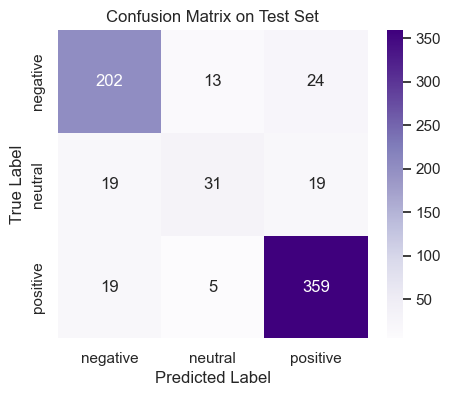

In [458]:
# Evaluate the tuned model on the test set
y_test_pred = grid_search_svm.best_estimator_.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")

# Generate a classification report for more detailed metrics
classification_rep_test = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:\n", classification_rep_test)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', 
            xticklabels=grid_search_svm.best_estimator_.classes_, 
            yticklabels=grid_search_svm.best_estimator_.classes_)

plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Development Without Filtering

In [9]:
df.head()

,Rating,Review,Skin Concern,Brand,Product Type,Review Len,Tokens,NoStopW Tokens,Lemmatized Tokens,Rating Class,Sentiment Label
0,1,i bought this because i’ve had really oily ski...,acne and oily,CeraVe,Cleanser,883,"['i', 'bought', 'this', 'because', 'i', '’', '...","['summer', 'cleared', 'visits', 'decided', 'hu...",summer cleared visit decided hurt heard terrib...,Low-rated,negative
1,1,i don’t understand how these brand name compan...,acne and oily,CeraVe,Cleanser,307,"['i', 'don', '’', 't', 'understand', 'how', 't...","['understand', 'companies', 'putting', 'parabe...",understand company putting parabens product wr...,Low-rated,negative
2,1,bought this for my child to use as a face wash...,acne and oily,CeraVe,Cleanser,728,"['bought', 'this', 'for', 'my', 'child', 'to',...","['child', 'breakout', 'tzone', 'caused', 'alle...",child breakout tzone caused allergic reaction ...,Low-rated,negative
3,1,"so, you know that slime you make when you mix ...",acne and oily,CeraVe,Cleanser,923,"['so', ',', 'you', 'know', 'that', 'slime', 'y...","['slime', 'mix', 'borax', 'glue', 'feels', 'fe...",slime mix borax glue feel feel slime gunky fra...,Low-rated,negative
4,1,i’m writing this review to hopefully save some...,acne and oily,CeraVe,Cleanser,670,"['i', '’', 'm', 'writing', 'this', 'review', '...","['writing', 'save', 'bad', 'not', 'caused', 'h...",writing save bad not caused horrible break out...,Low-rated,negative


## Data Splitting

In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
# First split: 70% train, 30% temporary (combined validation and test)
# Train-test split(from complete data)
X_train, X_temp, y_train, y_temp = train_test_split(df['Lemmatized Tokens'], df['Sentiment Label'], test_size=0.3, random_state=42)

# Validation-test split (from test data)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Feature Extraction

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer()  

# Fit the TF-IDF vectorizer on the training data and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data using the already fitted TF-IDF vectorizer
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

# Transform the test data using the already fitted TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print the shape of the transformed datasets to understand the feature space
print(f'Shape of TF-IDF transformed training data: {X_train_tfidf.shape}')
print(f'Shape of TF-IDF transformed validation data: {X_valid_tfidf.shape}')
print(f'Shape of TF-IDF transformed test data: {X_test_tfidf.shape}')

Shape of TF-IDF transformed training data: (5999, 9003)
Shape of TF-IDF transformed validation data: (1285, 9003)
Shape of TF-IDF transformed test data: (1286, 9003)


## MNB

Validation Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.74      0.71       480
     neutral       0.00      0.00      0.00       232
    positive       0.67      0.90      0.77       573

    accuracy                           0.68      1285
   macro avg       0.45      0.55      0.49      1285
weighted avg       0.56      0.68      0.61      1285



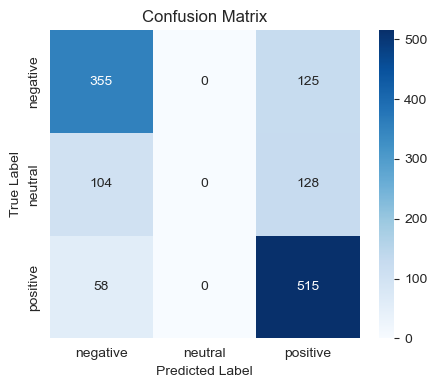

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Use Valid Data

# Initialize and train the Multinomial Naive Bayes model
nb_classifier = MultinomialNB()

# Train the model on the training data
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_valid_pred = nb_classifier.predict(X_valid_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_valid, y_valid_pred)
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the expanded parameter grid for MultinomialNB
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

# Create a MultinomialNB classifier object
nb_classifier_tuned = MultinomialNB()

# Initialize GridSearchCV with the MultinomialNB classifier and expanded parameter grid
grid_search_nb = GridSearchCV(nb_classifier_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_nb.fit(X_train_tfidf, y_train)

# Print the best parameters found
print("Best Parameters for MultinomialNB:", grid_search_nb.best_params_)

# Print the best cross-validation score found
print("Best Cross-validation Score for MultinomialNB:", grid_search_nb.best_score_)

Best Parameters for MultinomialNB: {'alpha': 0.5, 'fit_prior': True}
Best Cross-validation Score for MultinomialNB: 0.7026164859605227


Test Accuracy after Hyperparameter Tuning: 0.70
Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.70      0.78      0.74       476
     neutral       0.50      0.00      0.01       235
    positive       0.70      0.92      0.80       575

    accuracy                           0.70      1286
   macro avg       0.63      0.57      0.51      1286
weighted avg       0.66      0.70      0.63      1286



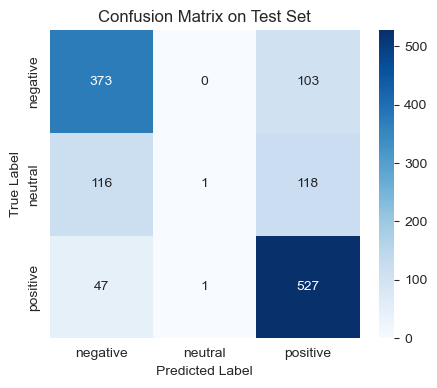

In [18]:
# Use Test Data

# Evaluate the tuned model on the test set
y_test_pred = grid_search_nb.best_estimator_.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")

# Generate a classification report for more detailed metrics
classification_rep_test = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:\n", classification_rep_test)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', 
            xticklabels=grid_search_nb.best_estimator_.classes_, 
            yticklabels=grid_search_nb.best_estimator_.classes_)

plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM

Validation Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

    negative       0.67      0.73      0.70       480
     neutral       0.34      0.14      0.20       232
    positive       0.74      0.85      0.79       573

    accuracy                           0.68      1285
   macro avg       0.58      0.58      0.56      1285
weighted avg       0.64      0.68      0.65      1285



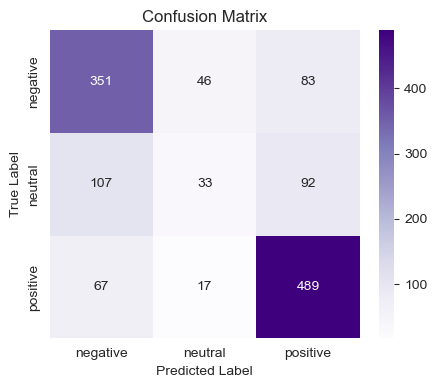

In [19]:
from sklearn.svm import SVC

# Using Valid Data

# Initialize and train the SVM classifier
svm_classifier = SVC(C=1, gamma='scale', kernel='linear') 

# Train the model on the training data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_valid_pred = svm_classifier.predict(X_valid_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_valid, y_valid_pred)
print("Classification Report:\n", classification_rep)

# Calculate confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='g', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Create an SVM classifier object
svm_classifier_tuned = SVC()

# Initialize GridSearchCV with the SVM classifier and parameter grid
grid_search_svm = GridSearchCV(svm_classifier_tuned, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_tfidf, y_train)

# Print the best parameters found
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Print the best cross-validation score found
print("Best Cross-validation Score for SVM:", grid_search_svm.best_score_)

Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-validation Score for SVM: 0.7022842646649987


Test Accuracy after Hyperparameter Tuning: 0.70
Classification Report on Test Set:
               precision    recall  f1-score   support

    negative       0.69      0.78      0.73       476
     neutral       0.40      0.15      0.22       235
    positive       0.76      0.86      0.81       575

    accuracy                           0.70      1286
   macro avg       0.61      0.60      0.59      1286
weighted avg       0.67      0.70      0.67      1286



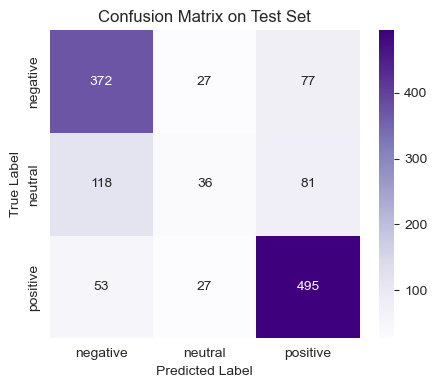

In [21]:
# Evaluate the tuned model on the test set
y_test_pred = grid_search_svm.best_estimator_.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after Hyperparameter Tuning: {test_accuracy:.2f}")

# Generate a classification report for more detailed metrics
classification_rep_test = classification_report(y_test, y_test_pred)
print("Classification Report on Test Set:\n", classification_rep_test)

# Calculate confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', 
            xticklabels=grid_search_svm.best_estimator_.classes_, 
            yticklabels=grid_search_svm.best_estimator_.classes_)

plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()